In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *
import sklearn

Couldn't import dot_parser, loading of dot files will not be possible.


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
from msm_resampled import *

In [5]:
%matplotlib inline

In [6]:
from detect_intermediates import *
from interpret_tICs import *

we are operating on biox3


In [7]:
from mor_h8_protein_ligand_feature_types import *
from get_variable_names import *
from mor_h8_protein_ligand_tica_config import *
from residue import Residue, Atom
from mor_h8_feature_types import feature_name_residues_dict


[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,

In [8]:
#feature_name = "bp_residues_4dkl_5c1m_restricted_pairs"
rho = 0.01
rho_string = "_rho0pt01-normalized"

feature_name = "bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF"
#rho = 0.0025
#rho_string = "_rho0pt0025-normalized"

lag_time=50
n_clusters=1000
n_components=10

In [9]:
feature_name

'bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF'

In [10]:
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
tica_dir = "%s-aromatic-binarize" %tica_dir
ori_tica_dir = copy.deepcopy(tica_dir)
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF
/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF


In [11]:
all_ligand_features_dir = "%s-with-aromatic" %features_dir
if not os.path.exists(all_ligand_features_dir): os.makedirs(all_ligand_features_dir)

In [12]:
ligand_residue = Residue(resSeq=1, chain_id="O", res_name="LIG")

In [13]:
active_crystal = md.load_frame([t for t in get_trajectory_files(traj_dir, traj_ext) if "suf" in t][0], index=0)
ligand = [r for r in active_crystal.topology.residues if "LIG" in str(r)][0]
ligand_atom_names = [a.name for a in ligand.atoms if "H" not in a.name]
print(ligand_atom_names)

[u'C13', u'C17', u'C18', u'C19', u'C22', u'C23', u'C24', u'C25', u'C26', u'C27', u'S1', u'O2', u'O3', u'N4', u'N5', u'C6', u'C7', u'C8', u'C9', u'C10', u'C11', u'C12', u'C14', u'C15', u'C16', u'C20', u'C21']


In [14]:
#ligand_atom_names = ["N1", "O1", "C7", "C17", "O2", "N2", "C26"]
ligand_atoms = []
for atom_name in ligand_atom_names:
    ligand_atoms.append(Atom(resSeq=1, chain_id="O", atom_name=atom_name, res_name="LIG"))

In [15]:
user_specified_atom_residue_pairs = [x for x in itertools.product(ligand_atoms, bp_residue_objects)]
user_specified_atom_residue_pairs = [ContactFeature(pair[0], pair[1]) for pair in user_specified_atom_residue_pairs]

In [16]:
len(user_specified_atom_residue_pairs)

2565

In [17]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
protein_file = "/home/enf/md_simulations/MOR/suf_ref.h5"
refined_atom_residue_pairs = compute_atom_residue_pairs_under_cutoff(ligand_atoms, bp_residue_objects, protein_file, cutoff=1., all_lig_atoms=True)

In [18]:
refined_atom_residue_pairs

[(LIG1-C13, VAL236),
 (LIG1-C13, ALA240),
 (LIG1-C13, CYS292),
 (LIG1-C13, TRP293),
 (LIG1-C13, PRO295),
 (LIG1-C13, ILE296),
 (LIG1-C13, HIS297),
 (LIG1-C13, ILE298),
 (LIG1-C13, TYR299),
 (LIG1-C13, VAL300),
 (LIG1-C13, ILE301),
 (LIG1-C13, TRP318),
 (LIG1-C13, HIS319),
 (LIG1-C13, CYS321),
 (LIG1-C13, ILE322),
 (LIG1-C13, ALA323),
 (LIG1-C13, LEU324),
 (LIG1-C13, GLY325),
 (LIG1-C13, TYR326),
 (LIG1-C13, THR327),
 (LIG1-C13, TYR75),
 (LIG1-C13, TYR148),
 (LIG1-C13, TYR149),
 (LIG1-C13, ASN150),
 (LIG1-C13, MET151),
 (LIG1-C13, PHE152),
 (LIG1-C13, ILE155),
 (LIG1-C13, VAL143),
 (LIG1-C13, ILE144),
 (LIG1-C13, ILE146),
 (LIG1-C13, ASP147),
 (LIG1-C13, THR120),
 (LIG1-C13, LEU121),
 (LIG1-C13, GLN124),
 (LIG1-C13, ALA117),
 (LIG1-C17, VAL236),
 (LIG1-C17, CYS292),
 (LIG1-C17, TRP293),
 (LIG1-C17, THR294),
 (LIG1-C17, PRO295),
 (LIG1-C17, ILE296),
 (LIG1-C17, HIS297),
 (LIG1-C17, ILE298),
 (LIG1-C17, TYR299),
 (LIG1-C17, VAL300),
 (LIG1-C17, ILE301),
 (LIG1-C17, TRP318),
 (LIG1-C17, HI

In [17]:
refined_atom_residue_pairs = [ContactFeature(pair[0], pair[1]) for pair in refined_atom_residue_pairs]
print(len(refined_atom_residue_pairs))


811


In [ ]:
from ipyparallel import Client
rc = Client  ()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

In [19]:
import residue
reload(residue)
from residue import *
aromatic_features_dir = "%s/suf_aromatic_features" %traj_dir
if not os.path.exists(aromatic_features_dir):
    os.makedirs(aromatic_features_dir)
aromatic_features_file = "%s/aromatic_features.dataset" %aromatic_features_dir
ring_dict = {}
suf_ring_dict = {}
suf_ring_dict["suf_ring1"] = [Atom(atom_name=n, res_name="LIG") for n in ["C22", "C17", "C13", "C18", "C23", "C25"]]
suf_ring_dict["suf_ring2"] = [Atom(atom_name=n, res_name="LIG") for n in ["C19", "S1", "C27", "C26", "C24"]]
ring_dict["tyr326_ring"] = [Atom(atom_name=n, res_name="TYR", resSeq=326) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["tyr148_ring"] = [Atom(atom_name=n, res_name="TYR", resSeq=148) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["tyr128_ring"] = [Atom(atom_name=n, res_name="TYR", resSeq=128) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["phe289_ring"] = [Atom(atom_name=n, res_name="PHE", resSeq=289) for n in ["CG", "CD2", "CE2", "CZ", "CE1", "CD1"]]
ring_dict["trp293_ring1"] = [Atom(atom_name=n, res_name="TRP", resSeq=293) for n in ["CD2", "CE2", "CZ2", "CH2", "CZ3", "CE3"]]
ring_dict["trp293_ring2"] = [Atom(atom_name=n, res_name="TRP", resSeq=293) for n in ["CG", "CD1", "NE1", "CE2", "CD2"]]
ring_dict["trp133_ring1"] = [Atom(atom_name=n, res_name="TRP", resSeq=133) for n in ["CD2", "CE2", "CZ2", "CH2", "CZ3", "CE3"]]
ring_dict["trp133_ring2"] = [Atom(atom_name=n, res_name="TRP", resSeq=133) for n in ["CG", "CD1", "NE1", "CE2", "CD2"]]
ring_dict["trp318_ring1"] = [Atom(atom_name=n, res_name="TRP", resSeq=318) for n in ["CD2", "CE2", "CZ2", "CH2", "CZ3", "CE3"]]
ring_dict["trp318_ring2"] = [Atom(atom_name=n, res_name="TRP", resSeq=318) for n in ["CG", "CD1", "NE1", "CE2", "CD2"]]
ring_dict["his297_ring"] = [Atom(atom_name=n, res_name="HIS", resSeq=297) for n in ["ND1", "CE1", "NE2", "CD2", "CG"]]
ring_dict["his319_ring"] = [Atom(atom_name=n, res_name="HIS", resSeq=319) for n in ["ND1", "CE1", "NE2", "CD2", "CG"]]

cation = Atom(atom_name="N4", res_name="LIG")

In [20]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *

import aromatic_featurizer
reload(aromatic_featurizer)
from aromatic_featurizer import *

In [21]:

pi_pi_ring_pairs = [(ring_dict["trp293_ring1"], ring_dict["phe289_ring"]), (ring_dict["trp293_ring2"], ring_dict["phe289_ring"])]
#ring_pairs = []
for i, ring_i in enumerate(suf_ring_dict.values()):
    for j, ring_j in enumerate(ring_dict.values()):
        pi_pi_ring_pairs.append((ring_i, ring_j))
cation_pi_pairs = [(cation, ring) for ring in ring_dict.values()]

In [ ]:
suf_traj_files = [t for t in get_trajectory_files(traj_dir, traj_ext) if "suf" in t]

compute_aromatic_features_wrapper(traj_dir, traj_ext, None, pi_pi_ring_pairs, cation_pi_pairs,
    aromatic_features_file, aromatic_features_dir, worker_pool=dview, 
    parallel=False, traj_files=suf_traj_files)


In [22]:
aromatic_feature_objects = get_aromatic_feature_names(pi_pi_ring_pairs, cation_pi_pairs)
aromatic_names = [str(a) for a in aromatic_feature_objects]
aromatic_names

['TRP293-CD2 to PHE289-CG: Pi Parallel',
 'TRP293-CG to PHE289-CG: Pi Parallel',
 'LIG-C22 to TRP293-CG: Pi Parallel',
 'LIG-C22 to TRP293-CD2: Pi Parallel',
 'LIG-C22 to TRP318-CG: Pi Parallel',
 'LIG-C22 to TYR326-CG: Pi Parallel',
 'LIG-C22 to PHE289-CG: Pi Parallel',
 'LIG-C22 to HIS319-ND1: Pi Parallel',
 'LIG-C22 to TRP133-CG: Pi Parallel',
 'LIG-C22 to TRP133-CD2: Pi Parallel',
 'LIG-C22 to TYR148-CG: Pi Parallel',
 'LIG-C22 to TRP318-CD2: Pi Parallel',
 'LIG-C22 to TYR128-CG: Pi Parallel',
 'LIG-C22 to HIS297-ND1: Pi Parallel',
 'LIG-C19 to TRP293-CG: Pi Parallel',
 'LIG-C19 to TRP293-CD2: Pi Parallel',
 'LIG-C19 to TRP318-CG: Pi Parallel',
 'LIG-C19 to TYR326-CG: Pi Parallel',
 'LIG-C19 to PHE289-CG: Pi Parallel',
 'LIG-C19 to HIS319-ND1: Pi Parallel',
 'LIG-C19 to TRP133-CG: Pi Parallel',
 'LIG-C19 to TRP133-CD2: Pi Parallel',
 'LIG-C19 to TYR148-CG: Pi Parallel',
 'LIG-C19 to TRP318-CD2: Pi Parallel',
 'LIG-C19 to TYR128-CG: Pi Parallel',
 'LIG-C19 to HIS297-ND1: Pi Parallel

In [ ]:
if not os.path.exists(features_dir): os.makedirs(features_dir)
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
import time
#time.sleep(60*120)
featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[], contact_residues=[],
                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs=user_specified_atom_residue_pairs, worker_pool=dview, excluded_trajs=["apo", "oxy", "bu"])

In [23]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
new_features_dir = "%s/reduced_features" %features_dir
if not os.path.exists(new_features_dir):
    os.makedirs(new_features_dir)
new_features_file = "%s/reduced_features.dataset" %new_features_dir
new_features_pkl = "%s/reduced_feature_names.pkl" %new_features_dir
#retain_features_within_range(features_dir, feature_residues_pkl, 0.66,
#                             0.01, new_features_file, new_features_pkl, worker_pool=dview)

In [24]:
with open(new_features_pkl) as f:
    new_feature_names = pickle.load(f)
    feature_residues = new_feature_names
print(new_feature_names)
print(len(new_feature_names))

[Lig1-C13 to Lys233, Lig1-C13 to Val236, Lig1-C13 to Phe237, Lig1-C13 to Ala240, Lig1-C13 to Trp293, Lig1-C13 to Ile296, Lig1-C13 to His297, Lig1-C13 to Tyr299, Lig1-C13 to Ala113, Lig1-C13 to Asp114, Lig1-C13 to Ala117, Lig1-C13 to Tyr148, Lig1-C13 to Asn150, Lig1-C13 to Met151, Lig1-C13 to Ser154, Lig1-C13 to Asp147, Lig1-C13 to Thr120, Lig1-C13 to Gln124, Lig1-C13 to Val300, Lig1-C13 to Trp318, Lig1-C13 to Cys321, Lig1-C13 to Ile322, Lig1-C13 to Gly325, Lig1-C13 to Tyr326, Lig1-C13 to Ser329, Lig1-C17 to Val236, Lig1-C17 to Phe237, Lig1-C17 to Ala240, Lig1-C17 to Trp293, Lig1-C17 to Ile296, Lig1-C17 to His297, Lig1-C17 to Ala113, Lig1-C17 to Asp114, Lig1-C17 to Thr118, Lig1-C17 to Ala117, Lig1-C17 to Tyr148, Lig1-C17 to Asn150, Lig1-C17 to Met151, Lig1-C17 to Ser154, Lig1-C17 to Asp147, Lig1-C17 to Thr120, Lig1-C17 to Tyr128, Lig1-C17 to Gln124, Lig1-C17 to Val300, Lig1-C17 to Trp318, Lig1-C17 to Cys321, Lig1-C17 to Ile322, Lig1-C17 to Ala323, Lig1-C17 to Leu324, Lig1-C17 to Gly325,

In [25]:
with open(feature_residues_pkl) as f:
    ori_feature_names = pickle.load(f)

In [ ]:
pool = mp.Pool(mp.cpu_count())
all_features_np = np.concatenate(pool.map(load_file,get_trajectory_files(features_dir, ".dataset")))
pool.terminate()

In [ ]:
all_features_df = pd.DataFrame(all_features_np, columns=[str(n) for n in ori_feature_names])

In [ ]:
plt.clf()
for n in all_features_df.columns.values.tolist():
    if "319" in n:
        plt.hist(all_features_df[n]*10., bins=50)
        plt.title(n)
        plt.show()

In [26]:
import pickle
reload(pickle)
with open(new_features_pkl, "rb") as f:
    feature_residues = pickle.load(f)
all_ligand_features_pkl = "%s/feature_names.pkl" %all_ligand_features_dir
all_ligand_feature_names = feature_residues + aromatic_names #[n for n in aromatic_names if "lig" in str(n).lower()]
all_ligand_feature_objects = feature_residues + aromatic_feature_objects #[n for n in aromatic_feature_objects if "lig" in str(n).lower()]
with open(all_ligand_features_pkl, "wb") as f:
    pickle.dump(all_ligand_feature_objects, f)
print(all_ligand_feature_objects)

[Lig1-C13 to Lys233, Lig1-C13 to Val236, Lig1-C13 to Phe237, Lig1-C13 to Ala240, Lig1-C13 to Trp293, Lig1-C13 to Ile296, Lig1-C13 to His297, Lig1-C13 to Tyr299, Lig1-C13 to Ala113, Lig1-C13 to Asp114, Lig1-C13 to Ala117, Lig1-C13 to Tyr148, Lig1-C13 to Asn150, Lig1-C13 to Met151, Lig1-C13 to Ser154, Lig1-C13 to Asp147, Lig1-C13 to Thr120, Lig1-C13 to Gln124, Lig1-C13 to Val300, Lig1-C13 to Trp318, Lig1-C13 to Cys321, Lig1-C13 to Ile322, Lig1-C13 to Gly325, Lig1-C13 to Tyr326, Lig1-C13 to Ser329, Lig1-C17 to Val236, Lig1-C17 to Phe237, Lig1-C17 to Ala240, Lig1-C17 to Trp293, Lig1-C17 to Ile296, Lig1-C17 to His297, Lig1-C17 to Ala113, Lig1-C17 to Asp114, Lig1-C17 to Thr118, Lig1-C17 to Ala117, Lig1-C17 to Tyr148, Lig1-C17 to Asn150, Lig1-C17 to Met151, Lig1-C17 to Ser154, Lig1-C17 to Asp147, Lig1-C17 to Thr120, Lig1-C17 to Tyr128, Lig1-C17 to Gln124, Lig1-C17 to Val300, Lig1-C17 to Trp318, Lig1-C17 to Cys321, Lig1-C17 to Ile322, Lig1-C17 to Ala323, Lig1-C17 to Leu324, Lig1-C17 to Gly325,

In [27]:
all_contact_features = load_file(new_features_file)
all_contact_features = [sklearn.preprocessing.binarize(f, 0.5) for f in all_contact_features]
aromatic_features = load_file(aromatic_features_file)
indices = [i for i in range(0,len(aromatic_names)) if "lig" in str(aromatic_names[i]).lower()]
print(indices)
#all_ligand_features = [np.hstack([all_contact_features[i], aromatic_features[i][:,indices]]) for i in range(0,len(all_contact_features))]
all_ligand_features = [np.hstack([all_contact_features[i], aromatic_features[i]]) for i in range(0,len(all_contact_features))]

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/reduced_features/reduced_features.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/trajectories/suf_aromatic_features/aromatic_features.dataset
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


In [101]:
#os.system("rm -rf %s" % tica_dir)
#lag_time = 5
#n_components = 5
#sparse = True
#wolf = True
#rho = 0.0025
#shrinkage = None
#traj_ext = ".h5"
import custom_tica
reload(custom_tica)
from custom_tica import *
fit_normalizer(features_dir, features=load_file(new_features_file))
#fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=False, features=load_file(new_features_file))
#fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=False, features=load_file(new_features_file))
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=False, partial_fit=False, features=all_ligand_features)

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/reduced_features/reduced_features.dataset
Saving "/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/normalizer.h5"... (<class 'sklearn.preprocessing.data.StandardScaler'>)
loading "/home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/normalizer.h5"...
loading feature files
(484, 790)
[ 1.  1.  1.  1.  1.  0.  1.  1.  1.  1.]
(754,)
fitting data to tICA model
transformed data with tICA model
Sparse time-structure based Independent Components Analysis (tICA)
------------------------------------------------------------------
n_components        : 10
shrinkage           : 0.0001350365372
lag_time            : 50
weighted_transform  : False
rho                 : 0.1
n_features          : 790

Top 5 timescales :
[ 321.07787976  279.66245538  263.29431157  202.30036389  172.45919905]

Top 5 eigenvalues 

In [28]:
tica_object = verboseload(projection_operator_dir)
tica_object.timescales_

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/phi_psi_chi2_allprot_tica_coords.h5"...


array([ 504.78114162,  372.49673239,  358.61170928,  273.53797964,
        237.55274292,  202.2235991 ,  198.24026682,  175.48641267,
        174.30970082,  171.59483716])

In [29]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
tic_components_dir = tica_dir
#important_contact_features, all_tIC_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, new_features_pkl, n_tica_components=n_components, percentile=95)
important_contact_features, all_tIC_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, all_ligand_features_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(19, 5)
residue_importances_df.shape
(23, 2)
                    feature_name      res_i      res_j  importance  \
14            Lig1-C20 To Trp293   Lig1-C20     Trp293   -0.690735   
17            Lig1-C20 To Cys321   Lig1-C20     Cys321    0.439213   
9              Lig1-O3 To Tyr299    Lig1-O3     Tyr299    0.412333   
12             Lig1-C8 To Val300    Lig1-C8     Val300    0.356012   
15            Lig1-C20 To Tyr299   Lig1-C20     Tyr299    0.347628   
8              Lig1-O2 To Tyr299    Lig1-O2     Tyr299    0.329015   
13             Lig1-C9 To Ala117    Lig1-C9     Ala117    0.308856   
2             Lig1-C22 To Ser329   Lig1-C22     Ser329    0.303660   
0             Lig1-C22 To Ile322   Lig1-C22     Ile322   -0.274661   
11             Lig1-C7 To Thr120    Lig1-C7     Thr120    0.256335   
16            Lig1-C20 To Trp318   Lig1-C20     Trp318   -0.242959   
6             Lig1-C25 To Asp114   Lig1-C25     Asp114    0.237674 

In [30]:
tic_subsampled_features_file= "%s/features_subsampled.pkl" % tica_dir



In [31]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

print tic_subsampled_features_file
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)
important_contact_features_pruned, important_contact_features_indices = find_non_zero_features(important_contact_features, feature_residues)
#subsample_features(features_dir, important_contact_features_indices, important_contact_features_pruned, tic_subsampled_features_file, features=load_file(new_features_file))

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/features_subsampled.pkl


TypeError: 'AromaticFeature' object is not iterable

In [32]:
tica_coords = verboseload(projected_features_dir)
print(np.shape(np.concatenate(tica_coords)))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/phi_psi_chi2_allprot_projected.h5"...
(272021, 10)


In [ ]:
import analysis
reload(analysis)
from analysis import *
plot_columns(tica_dir, projected_features_dir, titles = ["suf_tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

In [33]:
suf_trajs = []
apo_trajs = []
#trajs = [t for t in get_trajectory_files(traj_dir, traj_ext) if "apo_reimaged" not in t and "oxy" not in t]
trajs = [t for t in get_trajectory_files(traj_dir, traj_ext)]
for i, traj in enumerate(trajs):
    if "suf" in traj:
        suf_trajs.append(i)
    elif "apo" in traj:
        apo_trajs.append(i)

user_defined_coords = load_file(user_defined_features_file)

            

loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5"...


In [34]:
#pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t5_n_components5all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt0025"
pp_tica_dir = "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup"

In [35]:
protein_tica_file = "%s/phi_psi_chi2_allprot_projected.h5" %pp_tica_dir
protein_tica = verboseload(protein_tica_file)
protein_tica_suf = [protein_tica[i] for i in suf_trajs]

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/phi_psi_chi2_allprot_projected.h5"...


In [36]:
protein_tica_suf_conc = np.concatenate(protein_tica_suf)
ligand_tica_suf_conc =  np.concatenate(verboseload(projected_features_dir))

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/phi_psi_chi2_allprot_projected.h5"...


In [37]:
import plots
reload(plots)
from plots import *

#plot_data_vs_data(protein_tica_suf_conc, ligand_tica_suf_conc, ["mOR_tIC%d" %i for i in range(1,n_components+1)], ["suf_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

In [ ]:
n_clusters = 1000
clusterer_dir = "%s/sufclusterer_%dclusters.h5" % (tica_dir, n_clusters)
cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters, clusterer_dir)

In [ ]:
import custom_msm
reload(custom_msm)
from custom_msm import *
plot_timescales(clusterer_dir, n_clusters, tica_dir, main="", lag_times=list(range(1,51,10)))

In [ ]:
lag_time = 30
msm_model_dir = "%s/msm_lag_time%d.h5" % (tica_dir, lag_time)
if not os.path.exists(msm_model_dir):
    build_msm(clusterer_dir, lag_time=lag_time, msm_model_dir=msm_model_dir)
suf_msm = verboseload(msm_model_dir)

In [ ]:
'%s/suf_clusterer1000.h5' %pp_tica_dir

In [38]:
pp_msm_lag_time=25
pp_n_clusters = 1500
suf_pp_resampled_traj_to_frames_file = "%s/suf_msm_lag-time%d_prior-counts0.0_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters)
suf_pp_resampled_traj_to_frames = verboseload(suf_pp_resampled_traj_to_frames_file)
suf_pp_msm_file = "%s/suf_msm_lag-time%d_prior-counts0.0_clusters%d.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters)
suf_pp_msm = verboseload(suf_pp_msm_file)
suf_pp_clusterer = verboseload('%s/suf_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters))
suf_pp_clusters_map = make_clusters_map(suf_pp_clusterer)
suf_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
suf_pp_tic_components_dir = "%s" %pp_tica_dir
suf_pp_tica_dir = suf_pp_tic_components_dir
suf_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
pp_tic_subsampled_features = "%s/features_subsampled.pkl" %pp_tica_dir
suf_pp_tica = verboseload("%s/suf_tica_msm_lag-time%d_prior-counts0.0_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters))
suf_pp_pnas_file = "%s/suf_pnas_msm_lag-time%d_prior-counts0.0_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters)
suf_pp_pnas = verboseload(suf_pp_pnas_file)
suf_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir
suf_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors'

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/suf_msm_lag-time25_prior-counts0.0_clusters1500_resampled_20000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/suf_msm_lag-time25_prior-counts0.0_clusters1500.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/suf_clusterer1500.h5"...
350
17
6
1338
368
2
9
0
2
1
54
0
2
282
436
272
899
464
0
0
1331
1149
401
31
0
100
61
84
56
1
0
194
129
263
37
0
66
72
337
721
0
1154
450
28
30
10
33
1151
173
1747
11
51
181
202
502
241
0
739
43
1025
0
178
184
22
0
0
0
0
939
7
0
13
1
10
119
458
2658
101
366
43
374
0
1
486
3
237
18
16
62
0
8
116
0
105
33
62
0
163
913
3
94
746
103
836
0
23
530
300
6

In [39]:
pp_msm_lag_time=25
pp_n_clusters = 1500
apo_pp_resampled_traj_to_frames_file = "%s/apo_msm_lag-time%d_prior-counts0.0_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters)
apo_pp_resampled_traj_to_frames = verboseload(apo_pp_resampled_traj_to_frames_file)
apo_pp_msm_file = "%s/apo_msm_lag-time%d_prior-counts0.0_clusters%d.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters)
apo_pp_msm = verboseload(apo_pp_msm_file)
apo_pp_clusterer = verboseload('%s/apo_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters))
apo_pp_clusters_map = make_clusters_map(apo_pp_clusterer)
apo_pp_projection_operator_dir = "%s/phi_psi_chi2_allprot_tica_coords.h5" %pp_tica_dir
apo_pp_tica_file = "%s/apo_tica.h5" %pp_tica_dir
apo_pp_clusterer_file = '%s/apo_clusterer%d.h5' %(pp_tica_dir, pp_n_clusters)
apo_pp_tic_components_dir = "%s" %pp_tica_dir
apo_pp_tica_dir = apo_pp_tic_components_dir
apo_pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
pp_tic_subsampled_features = "%s/features_subsampled.pkl" %pp_tica_dir
apo_pp_tica = verboseload("%s/apo_tica_msm_lag-time%d_prior-counts0.0_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters))
apo_pp_pnas_file = "%s/apo_pnas_msm_lag-time%d_prior-counts0.0_clusters%d_resampled_20000.h5" %(pp_tica_dir, pp_msm_lag_time, pp_n_clusters)
apo_pp_pnas = verboseload(apo_pp_pnas_file)
apo_pp_ref_tica = "%s/reference_receptors/refcoords.csv" %pp_tica_dir
apo_pp_ref_features_dir = '/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors'

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/apo_msm_lag-time25_prior-counts0.0_clusters1500_resampled_20000.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/apo_msm_lag-time25_prior-counts0.0_clusters1500.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/apo_clusterer1500.h5"...
1
123
393
46
0
1
497
100
160
9
59
0
391
392
7
0
21
817
0
0
1
1284
7
262
184
269
264
20
0
974
2
58
218
104
84
161
27
52
0
1083
153
1812
64
355
261
0
106
20
313
1
235
434
260
343
0
2
131
1
110
973
113
0
1
112
53
0
169
0
1004
182
416
48
161
776
0
0
2
485
0
8
0
33
242
9
253
1
0
95
0
460
7
656
45
0
251
35
0
1
641
0
178
312
0
0
3
615
0
6
458
83
117
83


In [40]:
pp_analysis_dir = "%s-%sclusters_%dlag-time" %(analysis_dir, pp_n_clusters,pp_msm_lag_time)
analysis_dir = pp_analysis_dir
if not os.path.exists(analysis_dir):
    os.makedirs(analysis_dir)

In [41]:
pp_n_components=10
def get_features(features_dir):
    feature_files = get_trajectory_files(features_dir, ".dataset")
    features = np.vstack([load_file(f) for f in feature_files])
    print(features.shape)
    return features

pp_feature_residues_pkl = "/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/feature_residues.pkl"
with open(pp_feature_residues_pkl) as f:
    pp_feature_residues = pickle.load(f)
with open(new_features_pkl) as f:
    lp_feature_residues = pickle.load(f)

ref_pp_features = pd.DataFrame(get_features(suf_pp_ref_features_dir), columns=[str(f) for f in pp_feature_residues])
#ref_lp_features = pd.DataFrame(get_features(ref_features_dir), columns=[str(f) for f in lp_feature_residues])
ref_pp_tica = pd.read_csv(suf_pp_ref_tica, header=None)
ref_pp_tica.columns = ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]

#ref_lp_tica = pd.read_csv(ref_tica_coords, header=None)
#ref_lp_tica.columns=["suf tIC.%d" %i for i in range(1,n_components+1)]

ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

ref_pnas = pd.DataFrame(ref_pnas, columns=sorted(feature_name_residues_dict.keys()))

ref_features = pd.concat([ref_pp_features*10., ref_pp_tica, ref_pnas], axis=1)

loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors/4dkl_R_for_conformation.dataset
loading /home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/reference_receptors/5c1m.dataset
(2, 4440)
loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5"...


In [42]:
tica_coords = verboseload(projected_features_dir)
suf_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/suf.h5"
apo_pnas_file = "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/apo.h5"
suf_pnas = verboseload(suf_pnas_file)
apo_pnas = verboseload(apo_pnas_file)
suf_tica_file = '%s/suf_tica.h5' %pp_tica_dir
apo_tica_file = "%s/apo_tica.h5" %pp_tica_dir
suf_tica = verboseload(suf_tica_file)
apo_tica = verboseload(apo_tica_file)

suf_aromatic = load_file(aromatic_features_file)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/phi_psi_chi2_allprot_projected.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/suf.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/apo.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/suf_tica.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/apo_tica.h5"...
loading /home/enf/md_simulations/MOR/h8_reimaged/trajectories/suf_aromatic_features/aromatic_features.dataset


In [41]:
len(suf_aromatic)

754

In [42]:
len(aromatic_names)

64

In [43]:
pp_n_components = 10
suf_pnas_dfs = []
for array in suf_pnas:
    suf_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
suf_tica_dfs = []
for array in suf_tica:
    suf_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]))
lp_tica_dfs = []
for array in tica_coords:
    lp_tica_dfs.append(pd.DataFrame(array, columns=["suf tIC.%d" %i for i in range(1,n_components+1)]))
suf_feature_dfs = []
suf_features = load_file(new_features_file)
print("loaded suf features")
for array in suf_features:
    suf_feature_dfs.append(pd.DataFrame(array*10., columns=[str(f) for f in new_feature_names]))

suf_pi_dfs = []
for array in suf_aromatic:
    suf_pi_dfs.append(pd.DataFrame(array, columns=aromatic_names))
new_suf_feature_dfs = []
for i in range(0, len(suf_pi_dfs)):
    new_suf_feature_dfs.append(pd.concat([suf_pi_dfs[i], suf_feature_dfs[i]], axis=1))
suf_feature_dfs = new_suf_feature_dfs
    
pp_n_components = 10
apo_pnas_dfs = []
for array in apo_pnas:
    apo_pnas_dfs.append(pd.DataFrame(array, columns=sorted(feature_name_residues_dict.keys())))
apo_tica_dfs = []
for array in apo_tica:
    apo_tica_dfs.append(pd.DataFrame(array, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]))
tica_dfs = []
for array in tica_coords:
    tica_dfs.append(pd.DataFrame(array, columns=["apo tIC.%d" %i for i in range(1,n_components+1)]))



loading /home/enf/md_simulations/MOR/h8_reimaged/featuresbp_residues_4dkl_5c1m_restricted_pairs_10A-SUF/reduced_features/reduced_features.dataset
loaded suf features


In [44]:
suf_pnas = verboseload("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/suf.h5")
cluster_pnas_averages = calculate_cluster_averages_per_feature(suf_pp_clusterer, suf_pnas)
cluster_pnas_averages = pd.DataFrame(cluster_pnas_averages, columns=sorted(feature_name_residues_dict.keys()))
active_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_active"] > 0.2) & (cluster_pnas_averages["rmsd_npxxy_active"] < 0.25) & (cluster_pnas_averages["tm6_tm3_packing"] > 12.75) & (cluster_pnas_averages["tm6_tm3_packing"] < 13.25)]
inactive_clusters = cluster_pnas_averages.loc[(cluster_pnas_averages["rmsd_npxxy_inactive"] < 0.4) & (cluster_pnas_averages["rmsd_npxxy_inactive"] > 0.3) & (cluster_pnas_averages["tm6_tm3_packing"] > 8.0) & (cluster_pnas_averages["tm6_tm3_packing"] < 9.5)]
print(active_clusters.index.values)
print(inactive_clusters.index.values)



loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/suf.h5"...
[   3   13   21   38   41   42   47   48   59   63   80   87   91  100  101
  120  127  133  137  166  179  181  189  191  199  200  205  209  211  222
  227  246  251  256  258  262  267  268  290  297  303  312  317  326  332
  337  352  354  369  383  388  392  393  395  402  411  420  430  440  456
  461  467  470  475  476  489  511  515  518  527  534  535  542  552  557
  561  568  579  586  592  597  598  612  623  624  648  649  651  658  660
  667  675  676  677  689  694  701  706  719  724  728  744  775  790  802
  809  811  817  822  823  843  847  849  851  865  869  872  874  876  881
  882  884  893  899  909  910  937  938  943  944  945  953  961  962  963
  964  972  974  975  993 1008 1010 1048 1077 1097 1111 1113 1114 1140 1144
 1145 1146 1153 1159 1166 1179 1180 1199 1201 1204 1214 1222 1234 1236 1248
 1258 1262 1266 1293 1299 1302 1305 1308 1310 1325 1329 1333 1338 1359 1376
 1384 138

/home/enf/software/anaconda/lib/python2.7/site-packages/numpy-1.11.0-py2.7-linux-x86_64.egg/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [45]:
cluster_tica_averages = calculate_cluster_averages_per_feature(suf_pp_clusterer, suf_tica)
cluster_tica_averages = pd.DataFrame(cluster_tica_averages, columns=["tIC.%d" %i for i in range(1, pp_n_components+1)])
cluster_tica_pnas = pd.concat([cluster_pnas_averages, cluster_tica_averages], axis=1).dropna()
#set(cluster_tica_averages.loc[cluster_tica_averages["tIC.4"] > 0.].index.values.tolist()).intersection(set(active_clusters.index.values.tolist()))
#cluster_tica_pnas.loc[cluster_tica_pnas["tIC.5"] > 5.]

In [46]:
intermediate_actives = cluster_tica_averages.loc[(cluster_tica_averages["tIC.2"] > 0.7) & (cluster_tica_averages["tIC.2"] < 1.2) & (cluster_tica_averages["tIC.5"] > 0.) & (cluster_tica_averages["tIC.2"] > 0.8)].index.values
msm_intermediate_actives = suf_pp_msm.partial_transform(intermediate_actives)[0]
order = np.argsort(suf_pp_msm.populations_[msm_intermediate_actives])
print(suf_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])


[  3.75448339e-06   6.22070452e-06   6.22070459e-06   1.13582029e-05
   1.17026799e-05   1.27327299e-05   1.31486218e-05   1.50907749e-05
   1.61201032e-05   1.99748875e-05   2.44141049e-05   5.25551164e-05
   5.38087997e-05   5.56125814e-05   5.60572040e-05   6.64843690e-05
   7.11314214e-05   9.26980309e-05   9.95192930e-05   1.22300509e-04
   1.25611927e-04   1.30176609e-04   1.74410386e-04   2.02908386e-04
   2.16879005e-04   2.27334614e-04   2.29880431e-04   2.38454936e-04
   2.56018416e-04   2.65304305e-04   3.02310929e-04   3.02396996e-04
   3.11702125e-04   3.29926907e-04   3.34149026e-04   3.45658879e-04
   3.56004745e-04   3.61213966e-04   3.81932832e-04   3.92789007e-04
   4.21415501e-04   4.23770452e-04   4.26325597e-04   4.48855618e-04
   4.64018506e-04   4.70360842e-04   4.71230894e-04   4.84484613e-04
   5.23317015e-04   6.25525879e-04   6.77432498e-04   6.81520555e-04
   6.91489702e-04   7.10483936e-04   7.37812804e-04   8.16338889e-04
   8.72613503e-04   8.74840769e-04

In [46]:
#ligand_top_features = load_file(tic_subsampled_features_file)
protein_top_features = load_file(pp_tic_subsampled_features)
protein_top_features_apo = [protein_top_features[i]*10. for i in apo_trajs]
protein_top_features_suf = [protein_top_features[i]*10. for i in suf_trajs]



loading /home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/features_subsampled.pkl


In [47]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
suf_pp_all_features, suf_pp_tIC_features = interpret_tIC_components(suf_pp_projection_operator_dir, suf_pp_tic_components_dir, suf_pp_feature_residues_pkl, n_tica_components=n_components, percentile=95)

Interpreting tIC 1
feature_importances_df.shape
(5, 5)
residue_importances_df.shape
(6, 2)
           feature_name     res_i     res_j  importance               feature
2  Val66_Ca To Ile69_Ca  Val66_Ca  Ile69_Ca    0.716698  VAL66_CA to ILE69_CA
4  Val66_Ca To Ile71_Ca  Val66_Ca  Ile71_Ca   -0.487056  VAL66_CA to ILE71_CA
3  Thr67_Ca To Ile71_Ca  Thr67_Ca  Ile71_Ca    0.332113  THR67_CA to ILE71_CA
0        Val66 To Thr70     Val66     Thr70    0.258456        VAL66 to THR70
1  Thr67_Ca To Ile69_Ca  Thr67_Ca  Ile69_Ca   -0.229829  THR67_CA to ILE69_CA
Using dark_background
           residue  importance
Ile69_Ca  Ile69_Ca    0.669372
Val66_Ca  Val66_Ca    0.656510
Thr67_Ca  Thr67_Ca    0.304016
Ile71_Ca  Ile71_Ca    0.291155
Thr70        Thr70    0.258456
Val66        Val66    0.258456
Using dark_background
Interpreting tIC 2
feature_importances_df.shape
(1, 5)
residue_importances_df.shape
(2, 2)
      feature_name   res_i  res_j  importance          feature
0  Phe338 To Phe84  Phe338

In [46]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
sources = [suf_pp_msm.mapping_[i] for i in active_clusters.index.values if i in suf_pp_msm.mapping_.keys()]
sinks = [suf_pp_msm.mapping_[i] for i in inactive_clusters.index.values if i in suf_pp_msm.mapping_.keys()]
print(sources)
print(sinks)
suf_pp_tpt_paths_file = "%s/suf_clusterer1000_tpt_paths.h5" %pp_tica_dir
tpt_paths, inv_tpt_paths, _ = generate_tpt_traj_index_series(suf_pp_msm, sources=sources, sinks=sinks, clusters_map=suf_pp_clusters_map, num_paths=10, remove_path = 'subtract', save_file=suf_pp_tpt_paths_file)

[3, 11, 17, 31, 33, 34, 39, 40, 50, 53, 65, 70, 73, 80, 81, 97, 100, 106, 109, 133, 144, 146, 152, 154, 159, 160, 165, 168, 169, 179, 184, 198, 202, 205, 206, 210, 214, 215, 234, 240, 245, 251, 256, 263, 267, 272, 285, 287, 298, 308, 313, 317, 318, 320, 326, 333, 340, 346, 356, 369, 374, 380, 383, 388, 389, 401, 417, 421, 424, 432, 438, 439, 444, 454, 457, 460, 467, 474, 480, 486, 490, 491, 501, 508, 509, 528, 529, 530, 537, 539, 545, 550, 551, 552, 563, 567, 574, 579, 592, 596, 600, 612, 633, 644, 655, 662, 664, 669, 674, 675, 690, 693, 695, 697, 705, 708, 711, 713, 715, 720, 721, 723, 729, 734, 744, 745, 768, 769, 774, 775, 776, 784, 789, 790, 791, 792, 797, 798, 799, 814, 828, 829, 862, 889, 906, 920, 922, 923, 944, 947, 948, 949, 953, 959, 965, 977, 978, 996, 998, 1000, 1008, 1016, 1026, 1028, 1040, 1049, 1052, 1055, 1075, 1079, 1082, 1085, 1088, 1090, 1102, 1106, 1110, 1115, 1132, 1147, 1154, 1156, 1160, 1166, 1174, 1177, 1188, 1200, 1207, 1211, 1215, 1223, 1237, 1243, 1248]
[]


ValueError: attempt to get argmax of an empty sequence

In [ ]:
tm6_out_clusters = cluster_pnas_averages.loc[cluster_pnas_averages["tm6_tm3_packing"] > 12.75].index.values
sources = [suf_pp_msm.mapping_[i] for i in tm6_out_clusters if i in suf_pp_msm.mapping_.keys()]
sinks = copy.deepcopy(sources)
suf_pp_tpt_paths_file = "%s/suf_clusterer1000_tm6_out_tpt_paths.h5" %pp_tica_dir
tm6_tpt_paths, tm6_inv_tpt_paths, _ = generate_tpt_traj_index_series(suf_pp_msm, sources=sources, sinks=sinks, clusters_map=suf_pp_clusters_map, num_paths=5, remove_path = 'subtract', save_file=suf_pp_tpt_paths_file)

In [ ]:
sources

In [ ]:
inv_tpt_paths

In [76]:
#lig_features = list(set([str(g) for l in all_tIC_features for g in l]))
#prot_features = list(set([str(g) for l in suf_pp_tIC_features for g in l]))
#f0 = pd.concat([f*10. for f in ligand_top_features], axis=0)
#f0 = pd.concat([f*10. for f in ligand_top_features], axis=0)
#f1 = pd.concat([f*10. for f in protein_top_features_suf], axis=0)
#f2 = pd.concat([f for f in suf_tica_dfs])
#f3 = pd.concat([f for f in suf_pnas_dfs])
#prot_lig_features = pd.concat([f0,f1,f2,f3],axis=1)
all_traj_features = [pd.concat([suf_feature_dfs[i], protein_top_features_suf[i], suf_tica_dfs[i], suf_pnas_dfs[i]], axis=1) for i in range(0, len(suf_tica_dfs))]

In [ ]:
all_traj_features_np = [f.values for f in all_traj_features]
cluster_features_averages = calculate_cluster_averages_per_feature(suf_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features[0].columns)

In [83]:
inactive_clusters = cluster_features_averages.loc[cluster_features_averages["PHE289 to ASN150"] < 7.]

In [84]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
n_steps = 40000
save_file = "%s/msm%d_clusters_t25%d_lagtime%d_steps_2_inactive.h5" % (suf_pp_tica_dir, pp_n_clusters, pp_msm_lag_time, n_steps)
if not os.path.exists(save_file):
    msm_traj_index_pairs = generate_msm_traj_index_series(suf_pp_msm, random.choice(inactive_clusters.index.values.tolist()), n_steps, suf_pp_clusters_map, save_file)
else:
    msm_traj_index_pairs = verboseload(save_file)
protein_ligand_msm_featurized = resample_features_by_msm_trajectory(all_traj_features, msm_traj_index_pairs)

Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/msm1500_clusters_t2525_lagtime40000_steps_2_inactive.h5"... (<type 'list'>)


In [101]:
plmf = copy.deepcopy(protein_ligand_msm_featurized)
smoothing=100
names = plmf.columns.values.tolist()
for i, name in enumerate(names):
    if "LIG" in str(name):
        names[i] = "SUF" + name[3:]
    if "Lig1" in str(name):
        names[i] = "SUF" + name[4:]
plmf.columns = names
plmf.index = plmf.index.values * 25
plot_features = plmf[["tm6_tm3_packing", "PHE289 to ASN150", "TRP293 to ALA240", "ASN332_CA to TRP293_CA", "TYR336 to ASP114", "SUF-C9 to Tyr326", "SUF-C9 to Gln124", "SUF-O3 to Val300", "SUF-C20 to Ile322","SUF-C19 to TRP133-CD2: Pi T", "SUF-C22 to TRP293-CD2: Pi T"]]# "SUF-C19 to Trp133", "SUF-C22 to Tyr326"]]
plot_file = "%s/key_measurements_tIC5_4_smoothing%d.png" %(analysis_dir, smoothing)
#plot_df_rolling(plot_features.iloc[::1], plot_file, True, smoothing=smoothing, include_original=True, subplots=True, min_periods=None)
#plt.show()

In [102]:
plot_file

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1500clusters_25lag-time/key_measurements_tIC5_4_smoothing100.png'

In [71]:
"%s/key_measurements_tIC5_3.png" %(analysis_dir)

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1500clusters_25lag-time/key_measurements_tIC5_3.png'

In [52]:
analysis_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1500clusters_25lag-time'

In [53]:
projected_features = verboseload(projected_features_dir)
tica_resampled_file = os.path.join(tica_dir, "tica_msm_lag-time%d_clusters%d_resampled.h5" %(lag_time, n_clusters))
resample_features_by_msm_equilibirum_pop(projected_features, suf_pp_resampled_traj_to_frames, tica_resampled_file)
tica_resampled = verboseload(tica_resampled_file)
#plot_columns(tica_dir, tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_suf_BP_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/phi_psi_chi2_allprot_projected.h5"...
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/tica_msm_lag-time50_clusters1000_resampled.h5"... (<type 'numpy.ndarray'>)
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/tica_msm_lag-time50_clusters1000_resampled.h5"...


In [54]:
suf_pp_resampled_traj_index_pairs = []
for traj in suf_pp_resampled_traj_to_frames.keys():
    [suf_pp_resampled_traj_index_pairs.append((traj, frame)) for frame in suf_pp_resampled_traj_to_frames[traj]]

apo_pp_resampled_traj_index_pairs = []
for traj in apo_pp_resampled_traj_to_frames.keys():
    [apo_pp_resampled_traj_index_pairs.append((traj, frame)) for frame in apo_pp_resampled_traj_to_frames[traj]]

def create_features_eq_df(resampled_traj_index_pairs, feature_dfs, protein_top_features, ligand_top_features, pp_tica_resampled, ligand_tica_resampled, pp_pnas):
    all_dfs = []
    pp_features_eq = resample_features_by_msm_trajectory(protein_top_features, resampled_traj_index_pairs)
    all_dfs.append(pp_features_eq)
    if ligand_top_features is not None:
        ligand_features_eq = resample_features_by_msm_trajectory(ligand_top_features, resampled_traj_index_pairs)
        all_dfs.append(ligand_features_eq)
    pp_tica_eq = pd.DataFrame(pp_tica_resampled, columns=["mOR tIC.%d" %i for i in range(1,pp_n_components+1)])
    all_dfs.append(pp_tica_eq)
    if ligand_tica_resampled is not None:
        ligand_tica_eq = pd.DataFrame(ligand_tica_resampled, columns=["suf tIC.%d" %i for i in range(1,n_components+1)])
        all_dfs.append(ligand_tica_eq)
    pnas_eq = pd.DataFrame(pp_pnas, columns=sorted(feature_name_residues_dict.keys()))
    all_dfs.append(pnas_eq)
    features_eq = pd.concat(all_dfs, axis=1)
    features_eq.columns = [str(f) for f in features_eq.columns.values.tolist()]
    return features_eq

features_eq = create_features_eq_df(suf_pp_resampled_traj_index_pairs, suf_feature_dfs, protein_top_features_suf, suf_feature_dfs, suf_pp_tica, tica_resampled, suf_pp_pnas)
apo_features_eq = create_features_eq_df(apo_pp_resampled_traj_index_pairs, None, protein_top_features_apo, None, apo_pp_tica, None, apo_pp_pnas)

In [158]:
import sklearn
lig_names = suf_feature_dfs[0].columns.values.tolist()
a = features_eq[lig_names].values
print(a.shape)
b = features_eq[aromatic_names].values / 10.
print(b.shape)
x = np.nan_to_num(np.hstack([a, b]))
pm = compute_pearson_matrix(x, features_eq[["tm6_tm3_packing", "PHE289 to ASN150"]].values)
print(x.shape)
pmdf = pd.DataFrame(pm, columns=["a" , "b"], index=(lig_names+aromatic_names))
pmdf["b"].loc[[n for n in pmdf.index.values.tolist() if "trp" in n.lower() or "tyr" in n.lower() or "phe" in n.lower() or "his" in n.lower()]].dropna().sort(ascending=False,inplace=False)

(19980, 790)
(19980, 64)
(19980, 854)


Lig1-C18 to Trp293                      0.497218
Lig1-C10 to Tyr148                      0.487386
Lig1-C23 to Trp293                      0.483027
Lig1-C25 to Trp293                      0.474658
Lig1-C8 to Tyr148                       0.459501
Lig1-C13 to Trp293                      0.456783
Lig1-O3 to Tyr148                       0.454580
Lig1-C22 to Trp293                      0.440150
Lig1-C17 to Trp293                      0.389032
Lig1-C14 to Tyr148                      0.378509
Lig1-C16 to Trp293                      0.341957
Lig1-C23 to Tyr326                      0.318927
Lig1-C25 to Tyr326                      0.281476
Lig1-C21 to Trp293                      0.278529
Lig1-C20 to Trp318                      0.246850
Lig1-C11 to Tyr148                      0.237412
Lig1-C6 to Tyr148                       0.200372
Lig1-C18 to Tyr326                      0.188248
Lig1-O2 to Trp318                       0.183322
Lig1-C14 to Trp293                      0.183177
Lig1-C21 to His297  

In [55]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

(801,)


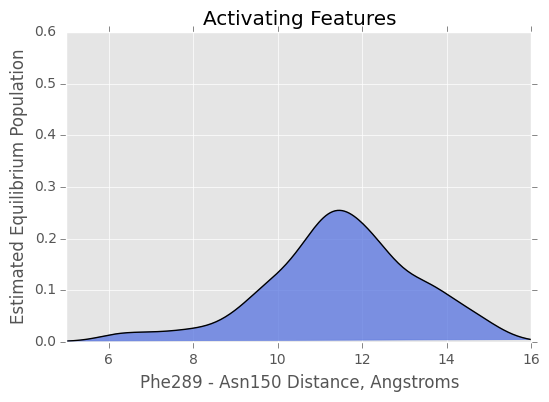

In [262]:
#activating_features = ["LIG-C19 to TRP318-CG: Pi T", "LIG-C19 to TRP318-CD2: Pi T", "LIG-C22 to HIS297-ND1: Pi T", "LIG-C19 to TYR326-CG: Pi T", "LIG-C19 to TYR326-CG: Pi Parallel", "LIG-C19 to HIS297-ND1: Pi T"]
activating_features = ["LIG-C19 to TRP318-CG: Pi T", "LIG-C19 to TRP318-CD2: Pi T"]
data_indices = []
for f in activating_features:
    data_indices += features_eq.loc[features_eq[f] == 10].index.values.tolist()
data = features_eq.iloc[list(set(data_indices))]["PHE289 to ASN150"]
#data = features_eq.loc[(features_eq['LIG-C19 to TRP318-CG: Pi T'] == 10) | (features_eq['LIG-C19 to TRP318-CD2: Pi T'] == 10)]["PHE289 to ASN150"].values
print(data.shape)
#data = features_eq.loc[(features_eq['TRP293-CD2 to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CD2 to PHE289-CG, Pi Parallel'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi Parallel'] == 0)]["tm6_tm3_packing"].values
title = "Activating Features" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s_7A.pdf" %(analysis_dir, title, xlabel)
custom_bounds = [features_eq["tm6_tm3_packing"].min(), features_eq["tm6_tm3_packing"].max()]
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])

(19179,)


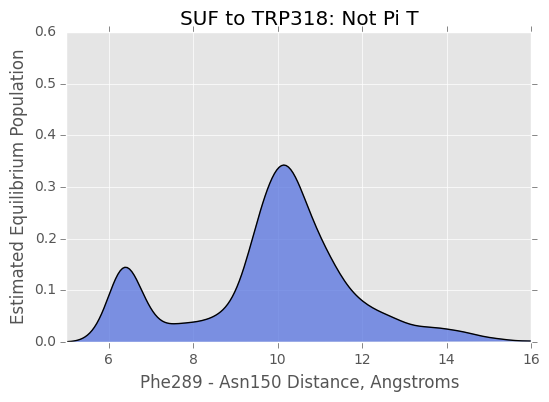

In [236]:
data = features_eq.loc[(features_eq['LIG-C19 to TRP318-CG: Pi T'] == 0) & (features_eq['LIG-C19 to TRP318-CD2: Pi T'] == 0)]["PHE289 to ASN150"].values
print(data.shape)
#data = features_eq.loc[(features_eq['TRP293-CD2 to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CD2 to PHE289-CG, Pi Parallel'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi Parallel'] == 0)]["tm6_tm3_packing"].values
title = "SUF to TRP318: Not Pi T" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s_7A.pdf" %(analysis_dir, title, xlabel)
custom_bounds = [features_eq["tm6_tm3_packing"].min(), features_eq["tm6_tm3_packing"].max()]
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])

(6792,)


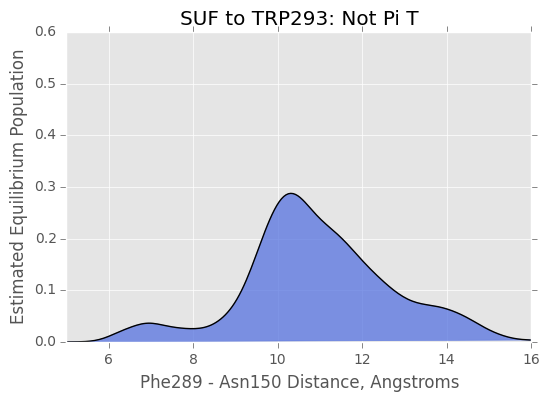

In [234]:
data = features_eq.loc[(features_eq['LIG-C22 to TRP293-CD2: Pi T'] == 0) & (features_eq['LIG-C22 to TRP293-CG: Pi T'] == 0)]["PHE289 to ASN150"].values
print(data.shape)
#data = features_eq.loc[(features_eq['TRP293-CD2 to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CD2 to PHE289-CG, Pi Parallel'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi Parallel'] == 0)]["tm6_tm3_packing"].values
title = "SUF to TRP293: Not Pi T" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s_7A.pdf" %(analysis_dir, title, xlabel)
custom_bounds = [features_eq["tm6_tm3_packing"].min(), features_eq["tm6_tm3_packing"].max()]
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])

In [69]:
features_eq.columns.values.tolist()

['MET281_CA to ILE107_CA',
 'ILE71 to TYR128',
 'THR67_CA to ILE69_CA',
 'HIS319_CA to THR67_CA',
 'ASN332_CA to TRP293_CA',
 'ALA68 to TYR128',
 'SER329_CA to VAL81_CA',
 'THR208_CA to CYS217_CA',
 'LEU176_CA to HIS171_CA',
 'ASN150_CA to ASP147_CA',
 'ILE234_CA to PHE239_CA',
 'TRP293 to ALA240',
 'ILE278_CA to LEU283_CA',
 'CYS321_CA to PRO295_CA',
 'TYR336_CA to VAL285_CA',
 'LYS174 to PHE178',
 'VAL300_CA to LYS233_CA',
 'PHE338_CA to ARG280_CA',
 'LEU231_CA to VAL236_CA',
 'TYR336 to PHE289',
 'ARG280_CA to LEU283_CA',
 'ASN150_CA to SER145_CA',
 'PHE338 to PHE84',
 'VAL66_CA to ILE69_CA',
 'ALA175_CA to ILE167_CA',
 'LYS174_CA to HIS171_CA',
 'VAL334_CA to VAL89_CA',
 'TYR336 to ASP114',
 'LEU232_CA to PHE237_CA',
 'THR67_CA to ILE71_CA',
 'TYR75_CA to LEU121_CA',
 'LEU339_CA to VAL282_CA',
 'VAL66_CA to ILE71_CA',
 'SER329_CA to ASP114_CA',
 'THR312_CA to THR315_CA',
 'VAL66 to THR70',
 'LEU335_CA to VAL284_CA',
 'HIS319_CA to TYR75_CA',
 'PHE237_CA to ILE234_CA',
 'TYR336_CA t

In [86]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *

we are operating on biox3


(7581,)


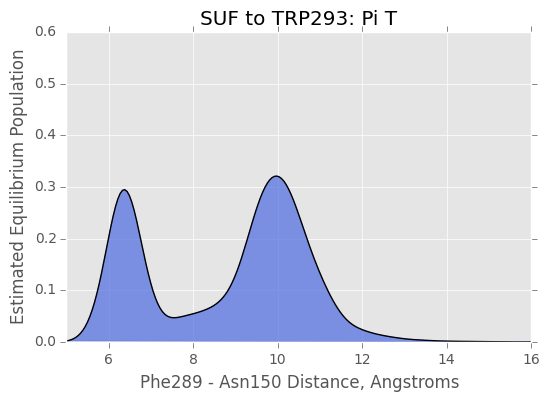

In [119]:
data = features_eq.loc[(features_eq['LIG-C22 to TRP293-CD2: Pi T'] == 10) | (features_eq['LIG-C22 to TRP293-CG: Pi T'] == 10)]["PHE289 to ASN150"].values
print(data.shape)
#data = features_eq.loc[(features_eq['TRP293-CD2 to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CD2 to PHE289-CG, Pi Parallel'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi T'] == 0) & (features_eq['TRP293-CG to PHE289-CG, Pi Parallel'] == 0)]["tm6_tm3_packing"].values
title = "SUF to TRP293: Pi T" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s.pdf" %(analysis_dir, title, xlabel)
custom_bounds = [features_eq["tm6_tm3_packing"].min(), features_eq["tm6_tm3_packing"].max()]
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])

(1778,)


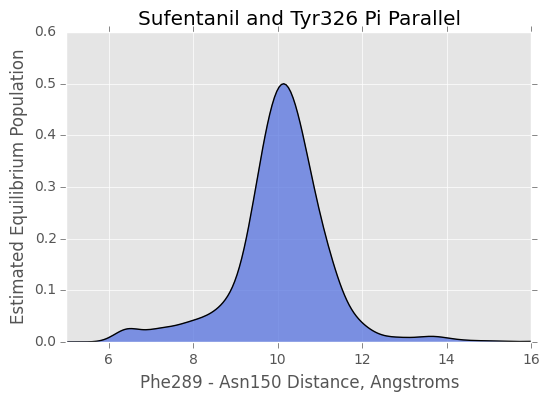

In [114]:
title = "Sufentanil and Tyr326 Pi Parallel" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s.pdf" %(analysis_dir, title, xlabel)
data = features_eq.loc[(features_eq['LIG-C22 to TYR326-CG: Pi Parallel'] == 10)]["PHE289 to ASN150"].values
print(data.shape)
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])
plt.show()

(18202,)


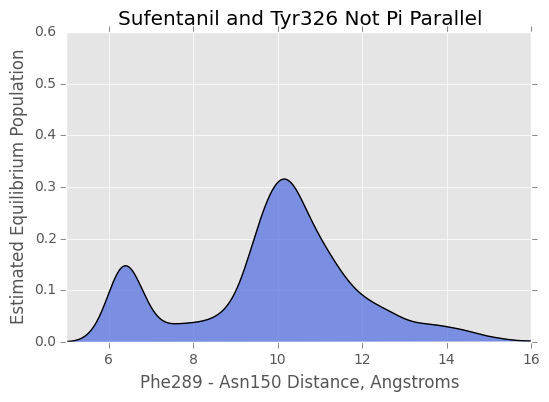

In [115]:
title = "Sufentanil and Tyr326 Not Pi Parallel" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s.pdf" %(analysis_dir, title, xlabel)
data = features_eq.loc[(features_eq['LIG-C22 to TYR326-CG: Pi Parallel'] == 0)]["PHE289 to ASN150"].values
print(data.shape)
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])
plt.show()

(19409,)


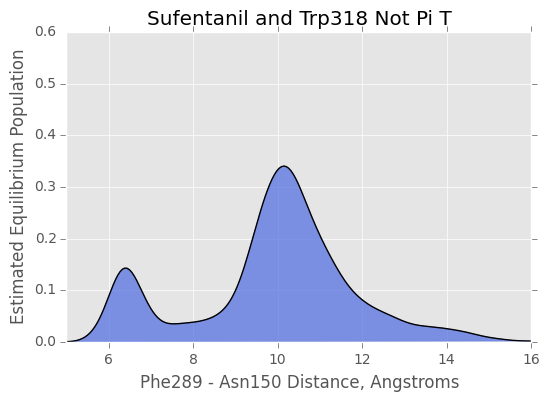

In [89]:
title = "Sufentanil and Trp318 Not Pi T" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s_2.pdf" %(analysis_dir, title, xlabel)
data = features_eq.loc[(features_eq['LIG-C19 to TRP318-CG: Pi T'] == 0) & (features_eq['LIG-C19 to TRP318-CD2: Pi T'] == 0)]["PHE289 to ASN150"].values
print(data.shape)
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])
plt.show()

(6889,)


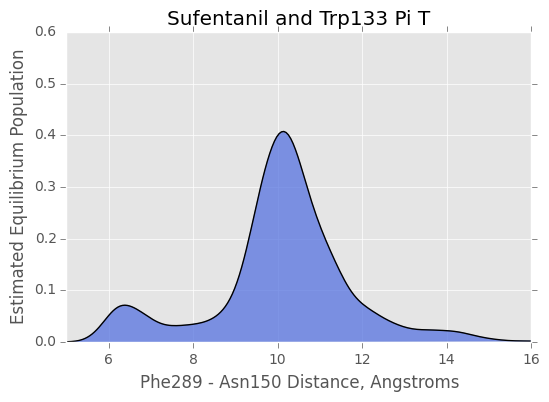

In [88]:
title = "Sufentanil and Trp133 Pi T" 
xlabel = "Phe289 - Asn150 Distance, Angstroms"
fig_file = "%s/%s_%s_2.pdf" %(analysis_dir, title, xlabel)
data = features_eq.loc[(features_eq['LIG-C19 to TRP133-CG: Pi Parallel'] == 1) | (features_eq['LIG-C19 to TRP133-CD2: Pi T'] == 1)]["PHE289 to ASN150"].values
print(data.shape)
compute_and_plot_single_kde(data, title, xlabel, fig_file, custom_bounds=[5,16], custom_y_bounds=[0,.6])
plt.show()

In [107]:
data.shape

(2982,)

In [ ]:
#pm = compute_pearson_matrix(features_eq["tm6_tm3_packing"].values.reshape((-1,1)), features_eq.values).reshape((-1,1))
titles_i = ["tm6_tm3_packing"] + pp_tica_eq.columns.values.tolist() + list(set(pp_features_eq.columns.values.tolist()))
titles_j = list(set(suf_features_eq.columns.values.tolist())) + suf_tica_eq.columns.values.tolist()
pm = compute_pearson_matrix(features_eq[titles_i].values, features_eq[titles_j].values)
pmdf = pd.DataFrame(pm, index=titles_i, columns=titles_j)

In [ ]:
pmdf.loc["tm6_tm3_packing"].sort(inplace=False)

In [ ]:
try:
    plt.rcParams['xtick.labelsize'] = 6.
    plt.rcParams['ytick.labelsize'] = 8.
    g = sns.clustermap(pmdf, figsize=(10,10))
    plt.show()
except:
    pass

In [ ]:
plt.hexbin(features_eq["Lig900-N1 to Tyr326"], features_eq["tm6_tm3_packing"])

In [ ]:
pmdf.loc[[str(f) for f in suf_features_eq.columns.values.tolist()]].abs().sort("correlation", ascending=False,inplace=False).iloc[:50].plot(kind='barh')

In [ ]:
import seaborn as sns
from scipy.stats import kendalltau
def hexbin(x, y, color, gridsize=25, n_colors=10, **kwargs):
    cmap = sns.light_palette(color, n_colors=n_colors, as_cmap=True)
    #cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=gridsize, cmap=cmap, **kwargs)
    
g = sns.PairGrid(features_eq[["tm6_tm3_packing", "rmsd_npxxy_inactive", "mOR tIC.4", "mOR tIC.6", "(MET281_CA, MET161_CA)", "(Lig900-C19, Gln124)", "(Lig900-C16, Val300)", "(Lig900-C8, Met151)", "(Lig900-N1, Tyr326)"]])# "(GLY82, TYR326)", "(TYR326, ASP147)", "suf tIC.3", "(Lig900-N1, Tyr326)", "(Lig900-C4, Tyr326)", "(Lig900-C20, Gln124)", "(Lig900-C6, Trp293)"]])
g.map_diag(plt.hist, bins=100)
#g.map_upper(sns.kdeplot, cmap="Blues_d", n_levels=10, shade=True, shade_lowest=False)
g.map_upper(plt.scatter, s=0.1, color="purple")
g.map_lower(plt.scatter, s=0.1, color="purple")

In [56]:
def custom_lim_finder(values):
    mins = np.min(values, axis=0)
    maxs = np.max(values, axis=0)
    stds = np.std(values, axis=0)
    custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]
    return custom_lims

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
#titles_i = ["tm6_tm3_packing", "mOR tIC.2"] + [str(f) for f in suf_pp_tIC_features[1]][:5] + ["suf tIC.3"] + [str(f) for f in all_tIC_features[2]][:5]
titles_i = ["tm6_tm3_packing"] + ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)] + ["suf tIC.%d" %i for i in range(1,n_components+1)]
features_eq_vals = features_eq[titles_i].values
mins = np.min(features_eq_vals, axis=0)
maxs = np.max(features_eq_vals, axis=0)
stds = np.std(features_eq_vals, axis=0)
custom_lims = [[mins[i] - 0.5*stds[i], maxs[i] + 0.5*stds[i]] for i in range(0,len(mins))]
jointplots(features_eq_vals, analysis_dir, titles = titles_i, main = "mOR MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=5., custom_lims=custom_lims, n_levels=15, worker_pool=None, parallel=True)

In [ ]:
from jointplot_d3 import *
titles_i = ["tm6_tm3_packing", "mOR tIC.2"] + [str(f) for f in suf_pp_tIC_features[1]] + ["mOR tIC.3"] + [str(f) for f in all_tIC_features[2]]
tica_resampled = np.vstack([verboseload(suf_pnas_resampled_file)[::1,], verboseload(apo_pnas_resampled_file)[::1,]])
mins = np.min(tica_resampled, axis=0)
maxs = np.max(tica_resampled, axis=0)
stds = np.std(tica_resampled, axis=0)
custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]
jointplots(features_eq[titles_i], analysis_dir, titles = titles_i, main = "mOR MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=5., custom_lims=custom_lims, n_levels=15)

In [ ]:
all_tIC_features[0]

In [ ]:
"""
['suf_reimaged_rep_100.h5', 'suf_reimaged_rep_119.h5', 'suf_reimaged_rep_179.h5', 'suf_reimaged_rep_184.h5', 'suf_reimaged_rep_186.h5', 'suf_reimaged_rep_24.h5', 'suf_reimaged_rep_255.h5', 'suf_reimaged_rep_27.h5', 'suf_reimaged_rep_56.h5', 'suf_reimaged_rep_58.h5', 'suf_reimaged_rep_59.h5', 'suf_reimaged_rep_63.h5', 'suf_reimaged_rep_64.h5', 'suf_reimaged_rep_83.h5', 'suf_rep_139.h5', 'suf_rep_84.h5']"""
suf_traj_names = [os.path.basename(t) for t in trajs if "suf" in t]
traj_idx = suf_traj_names.index('suf_rep_139.h5')
f = all_traj_features[traj_idx][["tm6_tm3_packing", "(Lig900-C20, Gln124)", "(Lig900-C3, Trp293)"]]
#f = protein_ligand_msm_featurized[f.columns.values]
pd.rolling_mean(f[f.columns.values[0]], window=50).plot()

In [ ]:
pd.rolling_mean(f[f.columns.values[1]], window=50).plot()

In [ ]:
pmdf.index.values

In [ ]:
suf_pp_pnas.T[1,:].shape

In [ ]:
from pandas.tools.plotting import scatter_matrix
#df = pd.concat([pp_features_eq, suf_features_eq], axis=1)[["(MET281_CA, MET161_CA)", "(Lig900-N1, Tyr326)"] + [str(f) for f in suf_pp_tIC_features[2][:2] +  all_tIC_features[2][:2]]]
df = features_eq[all_features[0]]
sm = scatter_matrix(df.iloc[::100], figsize=(6, 6), diagonal='kde')
[s.xaxis.label.set_rotation(90) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
plt.show()

In [ ]:
import seaborn as sns



g = sns.PairGrid(features_eq[all_features[0]])
g.map_upper(sns.jointplot, kind="hex", stat_func=kendalltau, color="#4CB391")
#cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
#g.map_lower(sns.kdeplot, cmap="Blues_d", n_levels=5, shade=True, shade_lowest=False)
#g.map_diag(sns.kdeplot)
#g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6)

In [90]:
import msm_resampled
reload(msm_resampled)
from msm_resampled import *
keep_steps = 100000
subsample = 100
ligand_msm_featurized_traj = resample_features_by_msm_trajectory(ligand_top_features, msm_traj_index_pairs[0:keep_steps])
protein_msm_featurized_traj = resample_features_by_msm_trajectory(protein_top_features_suf, msm_traj_index_pairs[0:keep_steps])
protein_msm_tica_traj = resample_features_by_msm_trajectory(suf_tica_dfs, msm_traj_index_pairs[0:keep_steps])
protein_msm_pnas_traj = resample_features_by_msm_trajectory(suf_pnas_dfs, msm_traj_index_pairs[0:keep_steps])
suf_msm_tica_traj = resample_features_by_msm_trajectory(tica_dfs, msm_traj_index_pairs[0:keep_steps])


protein_ligand_msm_featurized = pd.concat([ligand_msm_featurized_traj, protein_msm_featurized_traj, protein_msm_tica_traj, protein_msm_pnas_traj, suf_msm_tica_traj], axis=1)
plmf = protein_ligand_msm_featurized.iloc[::10]

In [ ]:
plt.scatter(pd.concat(all_traj_features, axis=0)["Lig1-N1 to Tyr326"].iloc[::100], pd.concat(all_traj_features, axis=0)["PHE289 to ASN150"].iloc[::100])
plt.show()

In [118]:
features_eq.loc[(features_eq["TRP293-CD2 to PHE289-CG: Pi Parallel"] == 1) | (features_eq["TRP293-CD2 to PHE289-CG: Pi T"] == 1) | (features_eq["TRP293-CG to PHE289-CG: Pi Parallel"] == 1) | (features_eq["TRP293-CG to PHE289-CG: Pi T"] == 1)].shape

(8713, 870)

In [119]:
apo_features_eq.loc[(features_eq["TRP293-CD2 to PHE289-CG: Pi Parallel"] == 1) | (features_eq["TRP293-CD2 to PHE289-CG: Pi T"] == 1) | (features_eq["TRP293-CG to PHE289-CG: Pi Parallel"] == 1) | (features_eq["TRP293-CG to PHE289-CG: Pi T"] == 1)].shape

(8707, 70)

In [128]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
intermediates = cluster_features_averages.loc[(cluster_features_averages["LIG-C19 TO TRP133-CD2: PI T"] > 0.5) & (cluster_features_averages["PHE289 to ASN150"] > 10.)].index.values
#intermediates = cluster_features_averages.loc[(cluster_features_averages["PHE289 to ASN150"] > 10.) & (cluster_features_averages["PHE289 to ASN150"] < 12.)].index.values
counts = [len(suf_pp_clusters_map[i]) for i in range(0, pp_n_clusters)]
for c in np.argsort(-1.0*np.array(counts)):
    if c in intermediates:
        print(c)
#intermediates = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 13.) & (cluster_features_averages["PHE289 to ASN150"] > 16.) & (cluster_features_averages["TYR336 to PHE289"] > 12.)].index.values# & (cluster_features_averages["Lig1-C9 to Trp318"] < 6.)].index.values
print(intermediates)
find_most_populated_intermediates(suf_pp_msm, intermediates)

we are operating on biox3


KeyError: 'LIG-C19 TO TRP133-CD2: PI T'

In [44]:

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 0.) & (cluster_features_averages["TYR336 to PHE289"] > 9.)].index.values
msm_intermediate_actives = np.concatenate(suf_pp_msm.partial_transform(intermediate_actives))
order = np.argsort(suf_pp_msm.populations_[msm_intermediate_actives])
print(np.sum(suf_pp_msm.populations_[msm_intermediate_actives][order]))
print(intermediate_actives[order])

0.057834507177
[ 644  516  408  541  779 1477 1471  417  926  906 1050 1169  145 1228  727
 1082 1175 1349   12 1035 1283  734 1414  886  787 1017  331 1134  237 1103
  753  488 1408  602  892 1099  546 1074  381  372 1085  696 1307  223   73
  478  481 1122 1117  523 1251  235 1078  156   86 1412  263  193 1242  443
  663  192  493  436  767 1221  449  250  136 1022   44   90  821 1263 1379
 1127   45  164  720  550  374  870  903   10  132  321  560  741 1246 1320
  346  159 1092  941  652  531  714 1332 1083  563  483  301 1155  917  270
 1063  608  217  174  435  140 1129   55 1046  934  609  198  887 1005 1027
  839  622  459  715 1328  106 1000  469]


In [ ]:
plt.hist(features_eq["TYR336 to PHE289"], bins=100)
plt.show()

In [ ]:
clus

In [ ]:
plt.clf()
plt.hist(cluster_features_averages["tm6_tm3_packing"].dropna().values, bins=50)
plt.show()

In [ ]:
[n for n in features_eq.columns.values.tolist() if "318" in n]

In [ ]:
plt.clf()
plt.hist(features_eq['Lig1-O2 to Trp318'], bins=50)
plt.show()

In [ ]:
suf_msm.inverse_transform(np.argsort(-1.*suf_msm.populations_))

In [ ]:
suf_msm.populations_[np.argsort(suf_msm.populations_)]

In [ ]:

all_traj_features_np = [f.values for f in all_traj_features_apo]

cluster_features_averages = calculate_cluster_averages_per_feature(apo_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features_apo[0].columns)

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.)].index.values
msm_intermediate_actives = np.concatenate(apo_pp_msm.partial_transform(intermediate_actives))
order = np.argsort(apo_pp_msm.populations_[msm_intermediate_actives])
print(np.sum(apo_pp_msm.populations_[msm_intermediate_actives][order]))
print(intermediate_actives[order])

tpt_paths_features = []
for tpt_path in inv_tpt_paths:
    tpt_paths_features.append(cluster_features_averages.iloc[tpt_path])

In [ ]:
all_traj_features_np[3]

In [ ]:
prot_features = list(set([str(g) for l in suf_pp_tIC_features for g in l]))
f1 = pd.concat([f*10. for f in protein_top_features_apo], axis=0)
f2 = pd.concat([f for f in apo_tica_dfs])
f3 = pd.concat([f for f in apo_pnas_dfs])
prot_lig_features = pd.concat([f1,f2,f3],axis=1)
all_traj_features_apo = [pd.concat([protein_top_features_apo[i]*10., apo_tica_dfs[i], apo_pnas_dfs[i]], axis=1) for i in range(0, len(apo_tica_dfs))]



all_traj_features_np = [f.values for f in all_traj_features_apo]
cluster_features_averages = calculate_cluster_averages_per_feature(apo_pp_clusterer, all_traj_features_np)
cluster_features_averages = pd.DataFrame(cluster_features_averages, columns=all_traj_features_apo[0].columns)

intermediate_actives = cluster_features_averages.loc[(cluster_features_averages["ASP114 to TYR336"] > 11.) & (cluster_features_averages["tm6_tm3_packing"] > 12.)].index.values
msm_intermediate_actives = apo_pp_msm.partial_transform(intermediate_actives)[0]
order = np.argsort(suf_pp_msm.populations_[msm_intermediate_actives])
print(suf_pp_msm.populations_[msm_intermediate_actives][order])
print(intermediate_actives)
print(intermediate_actives[order])

In [ ]:
tpt_paths_features[6]["Lig900-N1 to Tyr326"]

In [ ]:
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(PHE156, SER196)"] > 9.5) & (cluster_features_averages["(PHE156, SER196)"] < 10.5)].index)
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(PHE156, SER196)"] > 6.) & (cluster_features_averages["(PHE156, SER196)"] < 7.)].index)

In [ ]:
print(cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 11.) & (cluster_features_averages["(ASP114, TYR336)"] > 8.)& (cluster_features_averages["(Lig900-C19, Ile322)"] > 5.)].index)

In [ ]:
plt.hist(features_eq["Lig900-N1 to Tyr326"], bins=200)
plt.show()

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["mOR tIC.6"] > 4.)].index

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] < 10.) & (cluster_features_averages["rmsd_npxxy_inactive"]<0.3)].index

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 13.) & (cluster_features_averages["rmsd_npxxy_inactive"]<0.3)].index

In [ ]:
cluster_features_averages.loc[(cluster_features_averages["tm6_tm3_packing"] > 12.) & (cluster_features_averages["(VAL89_CA, TYR336_CA)"] >11.5)].index

In [ ]:
g = sns.PairGrid(prot_lig_features[["tm6_tm3_packing", "tIC.3", "(Lig900-C20, Gln124)", "(Lig900-C3, Trp293)"]])
g.map_diag(plt.hist, bins=100)
#g.map_upper(sns.kdeplot, cmap="Blues_d", n_levels=10, shade=True, shade_lowest=False)
g.map_upper(hexbin, color="purple", n_colors=30, gridsize=30)
g.map_lower(plt.scatter, s=.1)

In [ ]:
protein_top_features[0].iloc[::3]

In [ ]:
import seaborn as sns

In [ ]:
pmdf

In [ ]:
try:
    plt.rcParams['xtick.labelsize'] = 6.
    plt.rcParams['ytick.labelsize'] = 8.
    g = sns.clustermap(pmdf, figsize=(10,10))
    plt.show()
except:
    pass

In [ ]:
prot_lig_features.plot(kind='scatter', x="(MET281_CA, MET161_CA)", y= "(Lig900-C10, Val236)")

In [ ]:
plmf.columns.values

In [141]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
if not os.path.exists("%s/rfr_r2_scores.h5" %analysis_dir):
    r2_scores, importances = compute_rf_matrix(tica_resampled, suf_pp_tica, n_trees=500, n_folds=10)
    verbosedump(r2_scores, "%s/rfr_r2_scores.h5" %analysis_dir)
    verbosedump(importances, "%s/rfr_importances.h5" %analysis_dir)
else:
    r2_scores = verboseload("%s/rfr_r2_scores.h5" %analysis_dir)
    importances = verboseload("%s/rfr_importances.h5" %analysis_dir)

Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random/rfr_r2_scores.h5"... (<type 'list'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random/rfr_importances.h5"... (<type 'numpy.ndarray'>)


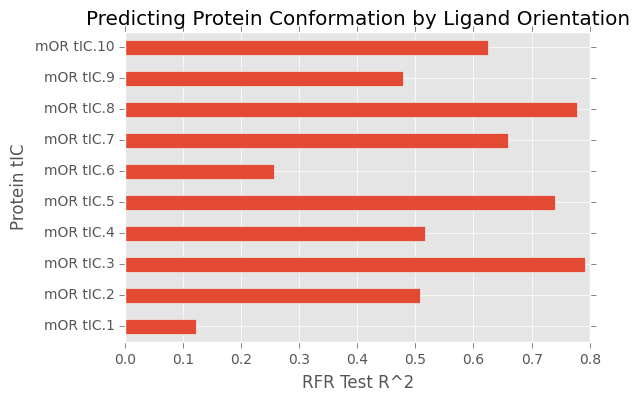

In [142]:
r2_scores_df = pd.Series(r2_scores, index=["mOR tIC.%d" %i for i in range(1, len(r2_scores)+1)])
title = "Predicting Protein Conformation by Ligand Orientation"
r2_scores_df.plot(kind='barh', title=title)
plt.xlabel("RFR Test R^2")
plt.ylabel("Protein tIC")
plt.savefig("%s/%s.pdf" %(analysis_dir, title))
plt.show()

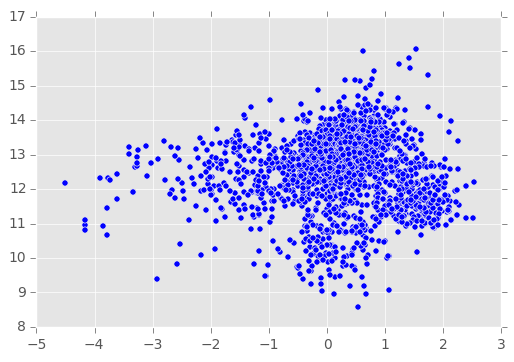

In [63]:
plt.scatter(features_eq["mOR tIC.10"].iloc[::10], features_eq["tm6_tm3_packing"].iloc[::10])
plt.show()

In [160]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
#if not os.path.exists("%s/rfr_r2_scores.h5" %analysis_dir):
#pd.concat([pp_features_eq, suf_features_eq, pp_tica_eq, suf_tica_eq, suf_pnas_eq], axis=1)
#y = pd.concat([pp_tica_eq, suf_pnas_eq["tm6_tm3_packing", "rmsd_npxxy_active"]], axis=1)
y = features_eq[["mOR tIC.%d" %i for i in range(1,pp_n_components+1)]]

#y = features_eq[protein_top_features[0].columns.values.tolist() + sorted(feature_name_residues_dict.keys()) + ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)] + [n for n in aromatic_names if "lig" not in n.lower()]]
#x = features_eq[[str(f) for f in new_feature_names]]
x = features_eq[[str(n) for n in all_ligand_feature_names] + ["suf tIC.%d" %i for i in range(1, n_components+1)]]

#if not os.path.exists("%s/all_features_rfc_scores.h5" %analysis_dir):
    #print("hi")
scores, importances = compute_rf_matrix(x.values, y.values, n_trees=500, n_folds=10)
verbosedump(scores, "%s/all_features_rfc_scores.h5" %analysis_dir)
verbosedump(importances, "%s/all_features_rfc_importances.h5" %analysis_dir)
#else:
#    scores = verboseload("%s/all_features_rfc_scores.h5" %analysis_dir)
#    importances = verboseload("%s/all_features_rfc_importances.h5" %analysis_dir)

Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random/all_features_rfc_scores.h5"... (<type 'list'>)
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random/all_features_rfc_importances.h5"... (<type 'numpy.ndarray'>)


In [159]:
features_eq["Lig1-C23 to Ala240"]

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
30       1
31       1
32       1
33       1
34       1
35       1
36       1
37       1
38       1
39       1
40       1
41       1
42       1
43       1
44       1
45       1
46       1
47       1
48       1
49       1
50       1
51       1
52       1
53       1
54       1
55       1
56       1
57       1
58       1
59       1
60       1
61       1
62       1
63       1
64       1
65       1
66       1
67       1
68       1
69       1
70       1
71       1
72       1
73       1
74       1
75       1
76       1
77       1
78       1
79       1
80       1
81       1
82       1
83       1
84       1
85       1
86       1
87       1
88       1
89       1
90       1

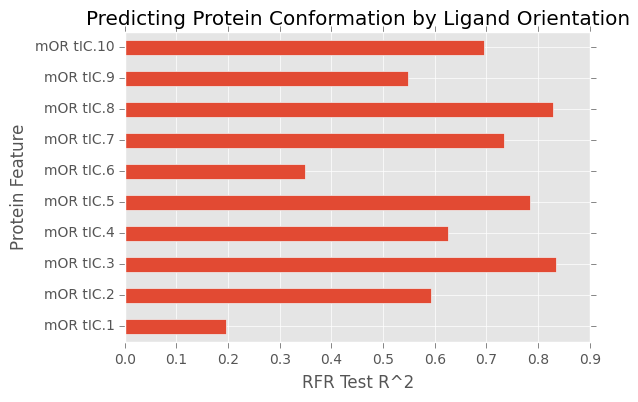

In [161]:
r2_scores_df = pd.Series(scores, index=y.columns)
title = "Predicting Protein Conformation by Ligand Orientation"
r2_scores_df.plot(kind='barh', title=title)
plt.xlabel("RFR Test R^2")
plt.ylabel("Protein Feature")
plt.show()
plt.savefig("%s/all_features_%s.pdf" %(analysis_dir, title))

In [60]:


#if not os.path.exists("%s/rfr_r2_scores.h5" %analysis_dir):
#pd.concat([pp_features_eq, suf_features_eq, pp_tica_eq, suf_tica_eq, suf_pnas_eq], axis=1)
#y = pd.concat([pp_tica_eq, suf_pnas_eq["tm6_tm3_packing", "rmsd_npxxy_active"]], axis=1)

y = features_eq[protein_top_features[0].columns.values.tolist() + sorted(feature_name_residues_dict.keys()) + ["mOR tIC.%d" %i for i in range(1,pp_n_components+1)] + [n for n in aromatic_names if "lig" not in n.lower()]]
x = sklearn.preprocessing.binarize(features_eq[[str(f) for f in new_feature_names]].values, 5.)
x = np.hstack([x, features_eq[[n for n in aromatic_names if "lig" in n.lower()]].values])
x = pd.DataFrame(x, columns = [str(f) for f in new_feature_names] + [n for n in aromatic_names if "lig" in n.lower()])
#x = features_eq[ligand_top_features[0].columns.values.tolist() + [n for n in aromatic_names if "lig" in n.lower()]]

#y_classified = copy.deepcopy(y.values)
#for j in range(0, y.values.shape[1]):
#    try:
#        minima = get_kde_mins(y.values[:,j])
#        y_classified[:,j] = multi_binarizer(y.values[:,j], minima)
#    except:
#        continue
#y_classified = pd.DataFrame(y_classified, columns = y.columns)



In [56]:
analysis_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1500clusters_25lag-time'

In [184]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *

we are operating on biox3


In [58]:
if not os.path.exists("%s/all_features_classified_rfc_scores.h5" %analysis_dir):
    scores, importances = compute_rf_matrix(x.values, y_classified.values, n_trees=500, max_depth=3, n_folds=10, task="classification")
    verbosedump(scores, "%s/all_features_classified_rfc_scores.h5" %analysis_dir)
    verbosedump(importances, "%s/all_features_classified_rfc_importances.h5" %analysis_dir)
else:
    scores = verboseload("%s/all_features_classified_rfc_scores.h5" %analysis_dir)
    importances = verboseload("%s/all_features_classified_rfc_importances.h5" %analysis_dir)

#if not os.path.exists("%s/all_features_rfr_r2_scores.h5" %analysis_dir):
#    print("hi")
#r2_scores, importances = compute_rf_matrix(x.values, y.values, n_trees=500, n_folds=10)
#verbosedump(r2_scores, "%s/all_features_rfr_r2_scores.h5" %analysis_dir)
#verbosedump(importances, "%s/all_features_rfr_importances.h5" %analysis_dir)
#else:
#r2_scores = verboseload("%s/all_features_rfr_r2_scores.h5" %analysis_dir)
#importances = verboseload("%s/all_features_rfr_importances.h5" %analysis_dir)

loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random/all_features_classified_rfc_scores.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random/all_features_classified_rfc_importances.h5"...


In [183]:
list(set(x['LIG-N4 to HIS297-ND1: Cation-Pi'].values.tolist()))

[0.0, 1.0]

In [112]:
y["PHE289 to ASN150"].loc[x['LIG-C22 to TYR326-CG: Pi Parallel']==10].shape

(7548,)

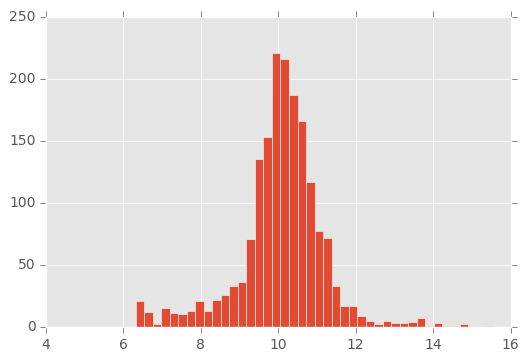

In [113]:
plt.clf()
plt.hist(y["PHE289 to ASN150"].loc[x['LIG-C22 to TYR326-CG: Pi Parallel']==10], bins=50,range=[5,16])
plt.show()

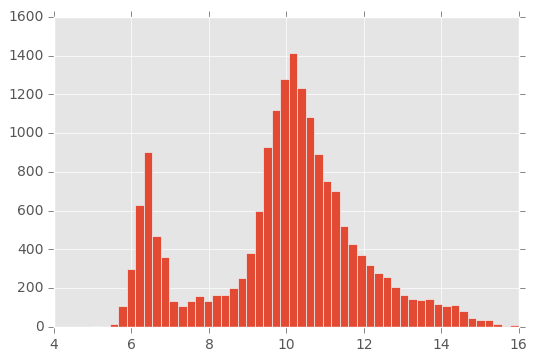

In [114]:
plt.clf()
plt.hist(y["PHE289 to ASN150"].loc[x['LIG-C22 to TYR326-CG: Pi Parallel']==0].values, bins=50, range=[5,16])
plt.show()

In [ ]:
print(importances.shape)
print(y.shape)
print(x.shape)

In [ ]:
plt.show()

In [59]:
scores_df = pd.Series(scores, index=y.columns)
scores_df.sort(inplace=False)

NameError: name 'y' is not defined

In [ ]:
#pearson_matrix = compute_pearson_matrix(x.values, y.values)
#pearson_df = pd.DataFrame(pearson_matrix, columns=y.columns, index=x.columns)
pearson_df["tm6_tm3_packing"].abs().sort(inplace=False)

In [73]:
importances_df = pd.DataFrame(importances, columns=y.columns, index=x.columns)
#importances_df["mOR tIC.5"].loc[[n for n in importances_df.index.values.tolist()]].abs().sort(inplace=False, ascending=False)
importances_df["PHE289 to ASN150"].abs().sort(inplace=False, ascending=False).iloc[:100]


Lig1-C20 to Ile322             0.054546
Lig1-C10 to Tyr148             0.051812
Lig1-C8 to Tyr148              0.044091
Lig1-O3 to Tyr148              0.044013
Lig1-C22 to Cys321             0.043739
Lig1-C25 to Cys321             0.042535
Lig1-C14 to Tyr148             0.028866
Lig1-C12 to Gln124             0.027583
Lig1-C18 to Met151             0.026958
Lig1-C7 to Tyr326              0.026622
Lig1-C17 to Tyr326             0.026618
Lig1-C9 to Gln124              0.025353
Lig1-C23 to Met151             0.023373
Lig1-C13 to Ile322             0.021927
Lig1-C18 to Trp293             0.020349
Lig1-C10 to Ile144             0.020290
Lig1-C14 to Asp147             0.018628
Lig1-O3 to Val300              0.018597
Lig1-N4 to Gln124              0.016683
Lig1-C9 to Tyr326              0.016456
Lig1-C21 to Val300             0.015683
Lig1-C13 to Trp293             0.014759
Lig1-O2 to Ile322              0.014693
Lig1-C25 to Ile322             0.012880
Lig1-C23 to Trp293             0.011973


In [157]:
analysis_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt05-normalized/analysis_n_clusters1000_random-1500clusters_25lag-time'

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


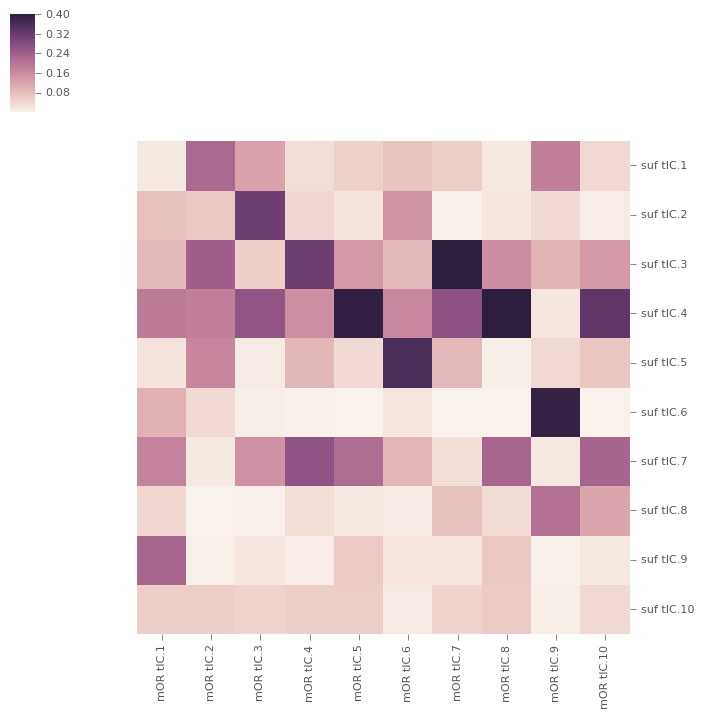

'\n\nplot_clustermap(importances_df, save_file="%s/feature_importances.pdf" %(save_dir, experiment_name), method=\'average\', z_score=None)\n\n\n\nfig = plt.figure()\nax = fig.add_subplot(111)\nheatmap = ax.pcolor(np.abs(pearson_matrix), cmap=plt.cm.Blues)\n\n# put the major ticks at the middle of each cell\nax.set_xticks(np.arange(pearson_matrix.shape[0])+0.5, minor=False)\nax.set_yticks(np.arange(pearson_matrix.shape[1])+0.5, minor=False)\n\n# want a more natural, table-like display\n#ax.invert_yaxis()\n#ax.xaxis.tick_top()\n\nax.set_xticklabels(row_labels, minor=False, rotation=270)\nax.set_yticklabels(column_labels, minor=False)\nfig.subplots_adjust(bottom=0.2)\n\nfig.savefig("%s/suf_vs_pp_pearson_heatmap.svg" % analysis_dir, format=\'svg\', dpi=1200)\nplot_file = "%s/suf_vs_pp_pearson_heatmap.pdf" % analysis_dir\npp = PdfPages(plot_file)\n\npp.savefig(fig)\n\npp.close()  \nplt.show()\n'

In [310]:
#import matplotlib
#matplotlib.style.use('ggplot')
#from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from plots import *
sc = StandardScaler()

#importances_scaled = pearson_matrix.T
#importances_scaled = sc.fit_transform(importances)
importances_scaled = copy.deepcopy(importances)
#for j in range(0, importances_scaled.shape[1]):
#    importances_scaled[:,j] *= r2_scores[j]

#responses_to_keep = np.where(np.array(r2_scores) > 0.5)[0]
#importances_scaled = importances_scaled[:,responses_to_keep]
#predictors_to_keep = list(set(np.where(importances_scaled > 0.03)[0].tolist()))
#print(responses_to_keep)
#print(predictors_to_keep)
#importances_scaled = importances_scaled[predictors_to_keep,:]
#print(len(responses_to_keep))

row_labels = ["suf tIC.%d" %i for i in range(1, n_components+1)]
column_labels = ["mOR tIC.%d" %i for i in range(1, pp_n_components+1)]
#row_labels = x.columns.values[predictors_to_keep]
#column_labels = y.columns.values[responses_to_keep]

importance_df = pd.DataFrame(importances_scaled, columns=column_labels, index=row_labels)

plot_clustermap(importance_df, save_file="%s/all_features_rfr_feature_importances.pdf" %(analysis_dir), method='average', row_cluster=False, col_cluster=False, z_score=None, xtick_labelsize=8, ytick_labelsize=8)
plt.show()

"""

plot_clustermap(importances_df, save_file="%s/feature_importances.pdf" %(save_dir, experiment_name), method='average', z_score=None)



fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = ax.pcolor(np.abs(pearson_matrix), cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(pearson_matrix.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(pearson_matrix.shape[1])+0.5, minor=False)

# want a more natural, table-like display
#ax.invert_yaxis()
#ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False, rotation=270)
ax.set_yticklabels(column_labels, minor=False)
fig.subplots_adjust(bottom=0.2)

fig.savefig("%s/suf_vs_pp_pearson_heatmap.svg" % analysis_dir, format='svg', dpi=1200)
plot_file = "%s/suf_vs_pp_pearson_heatmap.pdf" % analysis_dir
pp = PdfPages(plot_file)

pp.savefig(fig)

pp.close()  
plt.show()
"""

In [311]:
from jointplot_d3 import *
titles_j = [f for f in features_eq.columns.values if "Lig" in f and "Tyr326" in f]
print(titles_j)
jointplots(features_eq[titles_j].values, analysis_dir, titles=titles_j,
                           main = "mOR MSM", refcoords=None, refcoords_j=None, axes=None,
                               data_j=features_eq[["tm6_tm3_packing"]].values, titles_j=["tm6_tm3_packing"], reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    

['Lig1-C13 to Tyr326', 'Lig1-C17 to Tyr326', 'Lig1-C18 to Tyr326', 'Lig1-C19 to Tyr326', 'Lig1-C22 to Tyr326', 'Lig1-C23 to Tyr326', 'Lig1-C24 to Tyr326', 'Lig1-C25 to Tyr326', 'Lig1-C26 to Tyr326', 'Lig1-C27 to Tyr326', 'Lig1-S1 to Tyr326', 'Lig1-O2 to Tyr326', 'Lig1-O3 to Tyr326', 'Lig1-N4 to Tyr326', 'Lig1-N5 to Tyr326', 'Lig1-C6 to Tyr326', 'Lig1-C7 to Tyr326', 'Lig1-C8 to Tyr326', 'Lig1-C9 to Tyr326', 'Lig1-C10 to Tyr326', 'Lig1-C11 to Tyr326', 'Lig1-C12 to Tyr326', 'Lig1-C14 to Tyr326', 'Lig1-C15 to Tyr326', 'Lig1-C16 to Tyr326', 'Lig1-C20 to Tyr326', 'Lig1-C21 to Tyr326']
Making delta G plots.
Traceback (most recent call last):
  File "/home/enf/software/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1118, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
0
0
0
0
0
0
i=0
i=2
i=4
i=8
i=6
i=10
j=0
j=0
j=0
j=0
j=0
j=0
(19980, 27)
(19980, 27)
(19980, 27)
(19980, 27)
(19980, 27)
(19980, 27)
(19980, 1)
(19980, 1)
(19980, 1

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comp

  File "/home/enf/software/anaconda/lib/python2.7/inspect.py", line 1013, in getframeinfo
    lines, lnum = findsource(frame)
  File "/home/enf/software/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 160, in findsource
    file = getsourcefile(object) or getfile(object)
  File "/home/enf/software/anaconda/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "/home/enf/software/anaconda/lib/python2.7/inspect.py", line 490, in getmodule
    for modname, module in sys.modules.items():
KeyboardInterrupt



Unfortunately, your original traceback can not be constructed.



IndexError: string index out of range

r2_scores

In [64]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots(importances, plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=2, ref_df=None, save_dir=None):
    corr_matrix = importances.T
    ori_shape = np.shape(corr_matrix)
    
    if r2s is None:
        r2s = np.max(importances, axis=0)
    
    suf_order = np.argsort(-1.0*r2s)
    all_features = []
    if features is None:
        for k, prot_idx in enumerate(suf_order):
            if k == n_tICs:
                break
            lig_order = np.argsort(-1.0*importances[:,prot_idx])
            #if prot_idx != 9: continue
            print(lig_order)
            for l, lig_idx in enumerate(lig_order):
                if l == n_lig_tICs:
                    break
            
                features = []

                print("mOR tIC.%d" %(k+1))
                prot_features = ["mOR tIC.%d" %(prot_idx+1)]
                if custom_features is not None:
                    prot_features += custom_features[0]
                lig_features = ["suf tIC.%d" %(lig_idx+1)]
                all_prot_features = [str(f) for f in top_features_per_tIC_i[prot_idx]]
                all_lig_features = [str(f) for f in top_features_per_tIC_j[lig_idx]]
                pearson_matrix = compute_pearson_matrix(plmf[all_prot_features].values, plmf[all_lig_features].values)
                pearson_shape = pearson_matrix.shape
                inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(pearson_matrix).ravel()), pearson_shape))[0]
                prot_inds = []
                lig_inds = []

                for j, ind in enumerate([idx[0] for idx in inds]):
                    if len(prot_inds) == max_features: break
                    if ind in prot_inds: continue
                    prot_features.append(str(top_features_per_tIC_i[prot_idx][ind]))
                    prot_inds.append(ind)

                if custom_features is not None:
                    features += custom_features[0]

                for j, ind in enumerate([idx[1] for idx in inds]):
                    if len(lig_inds) == max_features: break
                    if ind in lig_inds: continue
                    lig_features.append(str(top_features_per_tIC_j[lig_idx][ind]))
                    lig_inds.append(ind)

                if make_jointplots:
                    print("Creating joint deltaG plots.")
                    data_i = features_eq[prot_features+all_prot_features].values
                    print(data_i.shape)
                    data_j = features_eq[lig_features+all_lig_features].values
                    print(data_j.shape)
                    tic_save_dir = "%s/mOR_tIC%d_vs_suf_tIC%d" %(save_dir, prot_idx+1, lig_idx+1)
                    if not os.path.exists(tic_save_dir):
                        os.makedirs(tic_save_dir)
                    #else:
                    #    continue
                    
                    
                    if ref_df is not None:
                        refcoords = ref_df[prot_features+all_prot_features].values
                        print(refcoords.shape)
                        refcoords_j = ref_df[lig_features+all_lig_features].values
                        print(refcoords_j.shape)
                    else:
                        refcoords = None
                        refcoords_j = None

                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                               data_j=data_j, titles_j=lig_features+all_lig_features, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    
                    jointplots(data_i, tic_save_dir, titles=prot_features+all_prot_features,
                               main = "mOR MSM", refcoords=refcoords, axes=None,
                               data_j=None, titles_j=None, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                    
                    jointplots(data_j, tic_save_dir, titles=lig_features+all_lig_features,
                           main = "mOR MSM", refcoords=refcoords_j, refcoords_j=refcoords, axes=None,
                               data_j=data_i, titles_j=prot_features+all_prot_features, reshape=False, max_tIC=20, 
                               min_density=None, max_diff=5., custom_lims=None, 
                               n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)

                features += (prot_features + lig_features)
    
                #plot_df_rolling(plmf[features].iloc[::subsample], "%s/key_measurements_tIC%d.pdf" %(save_dir, prot_idx+1), True, smoothing=smoothing, include_original=False, subplots=True, min_periods=None)
                #plt.show()  
                all_features.append(features)
    #features = ["tm6_tm3_packing", "rmsd_npxxy_active"]
    #features = ["mOR tIC.1", "mOR tIC.4", "mOR tIC.5"]
    #inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(corr_matrix).ravel()), ori_shape))[0]
    return all_features

jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

all_features= make_msm_features_plots(importances, protein_ligand_msm_featurized,
                                      suf_pp_tIC_features, all_tIC_features, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=5, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=None, save_dir=jointplots_dir)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "suf tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(suf_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), suf_pp_tIC_features, all_tIC_features, n_combs=2)

[1 3 6 0 2 9 8 4 5 7]
mOR tIC.1
Creating joint deltaG plots.
(19980, 13)
(19980, 7)
Making delta G plots.
Done plotting columns
Making delta G plots.
0
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDEComputed 2D KDEComputed 2D KDEComputed 2D KDEComputed 2D KDEComputed 2D KDE





min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





111111





i=0
i=1
i=2
i=3
i=4
i=5
j=1
j=1
j=1
j=1
j=1
j=1
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 13)
(199

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(19980, 7)
(19980, 7)
4
4
4
4
4
4
i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=4
j=4
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





555555





i=0
i=1
i=2
i=3
i=4
i=5
j=5
j=5
j=5
j=5
j=5
j=5
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(0.0, 5.0)
(2, 19980)
(2, 19980)
9


(2, 19980)
Computed 2D KDE
Computed 2D KDE
(2, 19980)
(2, 19980)
9Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE

Computed Density. Now plotting.

Computed Density. Now plotting.Computed Density. Now plotting.(2, 19980)

(0.0, 5.0)(0.0, 5.0)

Computed 2D KDE
(0.0, 5.0)

(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.
78


12

1011(0.0, 5.0)
(2, 19980)
9



(2, 19980)
Computed 2D KDE
(2, 19980)
(2, 19980)
(2, 19980)
10Computed 2D KDE
Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
Computed 2D KDE

Computed Density. Now plotting.
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(2, 19980)

(0.0, 5.0)


Computed 2D KDE
(0.0, 5.0)
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.
8



8
101112(0.0, 5.0)
9




(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
11Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Compu

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19980)
(19980, 13)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(19980, 13)
Computed 2D KDE
(2, 19980)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(2, 19980)
Computed Density. Now plotting.Computed 2D KDE



Computed 2D KDE

Computed Density. Now plotting.(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.(0.0, 5.0)





(0.0, 5.0)444(0.0, 5.0)4





4i=0
i=1
i=2
4i=4

j=4
j=4
j=4

j=4
i=5
(19980, 7)
(19980, 7)
(19980, 7)
i=3
(19980, 7)
j=4
(19980, 13)
(19980, 13)
(19980, 13)
j=4
(19980, 13)
(19980, 7)
(2, 19980)
(2, 19980)
(2, 19980)
(19980, 7)
(2, 19980)
(19980, 13)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(19980, 13)
Computed 2D KDE
(2, 19980)Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(2, 19980)
Computed Density. Now plotting.



Computed 2D KDE

Computed 2D KDE
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.(0.0, 5.0)Computed Density. Now plotting

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





444444





i=4
i=5
i=0
i=1
i=2
i=3
j=4
j=4
j=4
j=4
j=4
j=4
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 14)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

i=6
i=7


Computed 2D KDE
Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.11
i=9
i=10
j=11
j=11
(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.
Computed Density. Now plotting.

i=11
j=11
j=11
(19980, 13)
(19980, 13)



(0.0, 5.0)
(0.0, 5.0)i=8
j=11
(19980, 13)
(19980, 13)
(19980, 14)
(19980, 14)
45(0.0, 5.0)
(0.0, 5.0)
j=11
(19980, 13)
(19980, 14)
(19980, 14)
(2, 19980)
(2, 19980)



8
9(19980, 13)
(19980, 14)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
(2, 19980)
6
7
10
(19980, 14)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
(2, 19980)

(2, 19980)

(2, 19980)
(2, 19980)
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.

Computed Density. Now plotting.Computed 2D KDE
(2, 19980)
Computed 2D KDE
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.

(0.0, 5.0)(0.0, 5.0)
Computed Density. Now plotting.Computed 2D KDE
Com

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(19980, 13)
(19980, 13)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
(2, 19980)
(2, 19980)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
Computed 2D KDE



Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)444





444i=0
i=1
i=2



j=4
j=4
j=4
i=3
i=4
i=5
(19980, 14)
(19980, 14)
(19980, 14)
j=4
j=4
j=4
(19980, 13)
(19980, 13)
(19980, 13)
(19980, 14)
(19980, 14)
(19980, 14)
(2, 19980)
(2, 19980)
(2, 19980)
(19980, 13)
(19980, 13)
(19980, 13)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
(2, 19980)
(2, 19980)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
Computed 2D KDE



Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se









i=10
j=11
j=11

i=9
i=8
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)j=11
(19980, 14)
(19980, 14)
i=6
j=11
j=11






(19980, 14)
(19980, 13)
(19980, 13)
j=11
(19980, 14)
(19980, 14)
222222(19980, 13)
(2, 19980)
(2, 19980)
(19980, 14)
(19980, 13)
(19980, 13)






(2, 19980)
Computed 2D KDE
Computed 2D KDE
(19980, 13)
(2, 19980)
(2, 19980)
i=0
i=1
i=2
i=3
i=4
i=5
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.(2, 19980)
Computed 2D KDE
Computed 2D KDE
j=2
j=2
j=2
j=2
j=2
j=2
Computed Density. Now plotting.

Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)

(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.

(19980, 14)
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 14)
(0.0, 5.0)


(0.0, 5.0)(0.0, 5.0)3
3
3
3
3
3

1212(0.0, 5.0)

i=0
i=1
i=2
i=3
i=4
i=5
12


1212j=3
j=3
j=3
j=3
j=3
j=3

i=7
i=11
12

(19980, 10)
(19980, 10)


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19980)
(19980, 14)
Computed Density. Now plotting.(19980, 14)

(19980, 14)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
(2, 19980)

(2, 19980)
(2, 19980)
(2, 19980)



Computed Density. Now plotting.Computed 2D KDE
(0.0, 5.0)Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
Computed Density. Now plotting.
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.


(0.0, 5.0)
8


567
(0.0, 5.0)
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)


9
(2, 19980)



(2, 19980)
(2, 19980)
8
(2, 19980)
Computed 2D KDE

9Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0(2, 19980)

Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.
Computed 2D KDE
(2, 19980)



Computed Density. Now plotting.
Computed Density. Now plotting.Computed 2D KDE
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
Computed Density. Now plotting.



(0.0, 5.0)
769

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=4
j=4
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)







/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





333333





i=0
i=1
i=2
i=3
i=5
i=4
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





444444





i=0
i=1
i=2
i=3
i=5
i=4
j=4
j=4
j=4
j=4
j=4
j=4
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 1

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se



Computed 2D KDE
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE

Computed Density. Now plotting.Computed Density. Now plotting.min_density=0.0Computed Density. Now plotting.(0.0, 5.0)




(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.
(0.0, 5.0)7

(0.0, 5.0)

9
8

(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.

(0.0, 5.0)(0.0, 5.0)

9
(2, 19980)
Computed 2D KDE
Computed Density. Now plotting.
(0.0, 5.0)
Done plotting columns
[3 6 2 8 9 7 1 0 4 5]
mOR tIC.3
Creating joint deltaG plots.
(19980, 11)
(19980, 14)
Making delta G plots.
0
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=4
j=4
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)







/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19980)
(19980, 14)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed 2D KDE
(2, 19980)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.Computed 2D KDE



Computed Density. Now plotting.
Computed Density. Now plotting.(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)



(0.0, 5.0)
(0.0, 5.0)444
4



4
4i=0
i=1
i=2

i=4

j=4
j=4
j=4
i=3
j=4
i=5
(19980, 11)
(19980, 11)
(19980, 11)
j=4
(19980, 11)
j=4
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 11)
(19980, 14)
(19980, 11)
5
5
5
(19980, 14)
5
(19980, 14)
i=0
i=1
i=2
5
i=4
5
j=5
j=5
j=5
i=3
j=5
i=5
(19980, 11)
(19980, 11)
(19980, 11)
j=5
(19980, 11)
j=5
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 11)
(19980, 14)
(19980, 11)
(2, 19980)
(2, 19980)
(2, 19980)
(19980, 14)
(2, 19980)
(19980, 14)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed 2D KDE
(2, 19980)
Computed Density. Now plotting.Computed Density. Now plotting.C

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19980)

Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed 2D KDE
(2, 19980)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.Computed 2D KDE



Computed Density. Now plotting.
min_density=0.0(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)



(0.0, 5.0)
Computed Density. Now plotting.
789
8(0.0, 5.0)


10

(2, 19980)
(2, 19980)
(2, 19980)

(2, 19980)
8Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
9
Computed 2D KDE

Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(2, 19980)
min_density=0.0(2, 19980)



Computed 2D KDE

Computed 2D KDE
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)min_density=0.0Computed Density. Now plotting.
Computed Density. Now plotting.



(0.0, 5.0)
8910Computed Density. Now plotting.

(0.0, 5.0)


(0.0, 5.0)9
(2, 19980)
(2, 19980)
10


9Computed 2D KDE
Computed 2D KDE
(2, 19980)
10(2, 19980)

Computed Density. Now plotting.Comput

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19980)
(19980, 11)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed 2D KDE
(2, 19980)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.Computed 2D KDE



Computed Density. Now plotting.
Computed Density. Now plotting.(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)



(0.0, 5.0)
(0.0, 5.0)444
4



4
4i=0
i=1
i=2

i=4

j=4
j=4
j=4
i=3
j=4
i=5
(19980, 14)
(19980, 14)
(19980, 14)
j=4
(19980, 14)
j=4
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 14)
(19980, 11)
(19980, 14)
(2, 19980)
(2, 19980)
(2, 19980)
(19980, 11)
(2, 19980)
(19980, 11)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed 2D KDE
(2, 19980)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.Computed 2D KDE



Computed Density. Now plotting.
Computed Density. Now plotting.(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)





/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

i=13
Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(19980, 14)
j=3


Computed Density. Now plotting.


(19980, 11)
(19980, 14)
(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(2, 19980)
(19980, 11)


(0.0, 5.0)


Computed 2D KDE
(2, 19980)
33
333Computed Density. Now plotting.Computed 2D KDE


3



Computed Density. Now plotting.i=0
i=1

i=3
i=4
i=5
(0.0, 5.0)
j=3
j=3
i=2
j=3
j=3
j=3

(0.0, 5.0)(19980, 11)
(19980, 11)
j=3
(19980, 11)
(19980, 11)
(19980, 11)
4
(19980, 10)
(19980, 10)
(19980, 11)
(19980, 10)
(19980, 10)
(19980, 10)

44
4
(19980, 10)
4
4
4
i=12

i=0
i=1
4
i=3
i=4
i=5
j=4
i=13
j=4
j=4
i=2
j=4
j=4
j=4
(19980, 14)
j=4
(19980, 11)
(19980, 11)
j=4
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 14)
(19980, 10)
(19980, 10)
(19980, 11)
(19980, 10)
(19980, 10)
(19980, 10)
(2, 19980)
(19980, 11)
(2, 19980)
(2, 19980)
(19980, 10)
(2, 19980)
(2, 199

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.min_density=0.0





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.





(0.0, 5.0)789108





8(2, 19980)
(2, 19980)
(2, 19980)
9
(2, 19980)

Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed 2D KDE
(2, 19980)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
min_density=0.0Computed 2D KDE



min_density=0.0
Computed Density. Now plotting.(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
Computed Density. Now plotting.




Computed Density. Now plotting.
(0.0, 5.0)(0.0, 5.0)8910(0.0, 5.0)





99(2, 19980)
(2, 19980)
10
10

Computed 2D KDE
Computed 2D KDE
(2, 19980)

(2, 19980)
(2, 19980)
Computed Density. Now plotting.Comput

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se




7i=0
i=1
i=2
i=3
i=4

j=7
j=7
j=7
j=7
j=7
i=5
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
j=7
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 10)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(19980, 11)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE





Computed Density. Now plotting.(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





(0.0, 5.0)88888





8i=0
i=1
i=2
i=3
i=4

j=8
j=8
j=8
j=8
j=8
i=5
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
j=8
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 10)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(19980, 11)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)Computed Density. Now plotting.Com

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.


Computed Density. Now plotting.

(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)(0.0, 5.0)


(0.0, 5.0)

444
44


4

i=0
i=1
i=2

i=4
i=5
j=4
j=4
j=4
i=3
j=4
j=4
(19980, 12)
(19980, 12)
(19980, 12)
j=4
(19980, 12)
(19980, 12)
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 12)
(19980, 14)
(19980, 14)
5
5
5
(19980, 14)
5
5
i=0
i=1
i=2
5
i=4
i=5
j=5
j=5
j=5
i=3
j=5
j=5
(19980, 12)
(19980, 12)
(19980, 12)
j=5
(19980, 12)
(19980, 12)
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 12)
(19980, 14)
(19980, 14)
(2, 19980)
(2, 19980)
(2, 19980)
(19980, 14)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotti

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Computed 2D KDE
8Computed Density. Now plotting.Computed 2D KDE



Computed Density. Now plotting.

Computed Density. Now plotting.(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
(2, 19980)
(0.0, 5.0)



(0.0, 5.0)Computed 2D KDE

(0.0, 5.0)678
Computed Density. Now plotting.11



10

(2, 19980)
(2, 19980)
9

(0.0, 5.0)(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
(2, 19980)

Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
9


Computed Density. Now plotting.Computed Density. Now plotting.
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)

(2, 19980)



(0.0, 5.0)(0.0, 5.0)Computed 2D KDE
878

Computed Density. Now plotting.


1011
(2, 19980)
(2, 19980)
9


(0.0, 5.0)Computed 2D KDE
Computed 2D KDE
(2, 19980)
(2, 19980)
(2, 19980)

min_density=0.0Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
10

Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.
Co

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(19980, 12)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.



Computed Density. Now plotting.
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)



(0.0, 5.0)
4444
4



4
i=0
i=1
i=2
i=3

i=5
j=4
j=4
j=4
j=4
i=4
j=4
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 14)
j=4
(19980, 14)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 14)
(19980, 12)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(19980, 12)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.



Computed Density. Now plotting.
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)





/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se


j=0
(0.0, 5.0)j=0
(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)(0.0, 5.0)(19980, 14)

(19980, 14)


2

(19980, 12)
2(19980, 12)
22
22(2, 19980)

(2, 19980)


i=5


Computed 2D KDE
i=2
Computed 2D KDE
i=0
i=1
j=2
i=4
i=3
min_density=0.0j=2
min_density=0.0j=2
j=2
(19980, 12)
j=2
j=2

(19980, 12)

(19980, 12)
(19980, 12)
(19980, 10)
(19980, 12)
(19980, 12)
Computed Density. Now plotting.
(19980, 10)
Computed Density. Now plotting.
(19980, 10)
(19980, 10)
(2, 19980)
(19980, 10)
(19980, 10)
(0.0, 5.0)(2, 19980)
(0.0, 5.0)(2, 19980)
(2, 19980)
Computed 2D KDE
(2, 19980)
(2, 19980)

Computed 2D KDE

Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
1Computed Density. Now plotting.1Computed Density. Now plotting.Computed Density. Now plotting.
Computed Density. Now plotting.Computed Density. Now plotting.




(0.0, 5.0)

i=12
(0.0, 5.0)i=13
(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)(0.0, 5.0)j=1

j=1


3

(19980, 14)
3(19980, 14)
33
33(19980, 12)

(19980, 12)


i=5


(2, 1

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se







j=9
i=9
i=7
j=9
j=9
456789(19980, 12)
j=9
j=9
(19980, 12)
(19980, 12)






(19980, 10)
(19980, 12)
(19980, 12)
(19980, 10)
(19980, 10)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(19980, 10)
(19980, 10)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
7
Computed 2D KDE
Computed 2D KDE
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.(2, 19980)
Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.



Computed 2D KDE


Computed Density. Now plotting.Computed Density. Now plotting.

(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)min_density=0.0(0.0, 5.0)(0.0, 5.0)

(0.0, 5.0)(0.0, 5.0)






(0.0, 5.0)(0.0, 5.0)

5678Computed Density. Now plotting.
10






(0.0, 5.0)(2, 19980)

9
(2, 19980)


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=4
j=4
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)







/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se



i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=4
j=4
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





555555





i=0
i=1
i=2
i=3
i=4
i=5
j=5
j=5
j=5
j=5
j=5
j=5
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.C

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se


(2, 19980)
Computed 2D KDE
Computed 2D KDE
(2, 19980)
(2, 19980)
9Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE

min_density=0.0

Computed Density. Now plotting.Computed Density. Now plotting.(2, 19980)

(0.0, 5.0)(0.0, 5.0)

Computed 2D KDE
Computed Density. Now plotting.


(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.(0.0, 5.0)78





109(0.0, 5.0)9(2, 19980)
9




Computed 2D KDE
(2, 19980)
(2, 19980)
(2, 19980)
10(2, 19980)
Computed Density. Now plotting.Computed 2D KDE
Computed 2D KDE
Computed 2D KDE

Computed 2D KDE

Computed Density. Now plotting.Computed Density. Now plotting.min_density=0.0(2, 19980)
Computed Density. Now plotting.(0.0, 5.0)


Computed 2D KDE


(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.
Computed Density. Now plotting.(0.0, 5.0)8

(0.0, 5.0)


10
(0.0, 5.0)109


10
(2, 19980)
(2, 19980)
(2, 19980)

10Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)

Computed Density. Now p

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se


7

i=0
i=1
i=2

i=3
i=5
j=7
j=7
j=7
i=4
j=7
j=7
(19980, 8)
(19980, 8)
(19980, 8)
j=7
(19980, 8)
(19980, 8)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 8)
(19980, 11)
(19980, 11)
(2, 19980)
(2, 19980)
(2, 19980)
(19980, 11)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.


Computed Density. Now plotting.

(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)(0.0, 5.0)


(0.0, 5.0)

0
0

i=6
i=7
j=0
j=0
(19980, 8)
(19980, 8)
(19980, 11)
(19980, 11)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0

Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 5.0)(0.0, 5.0)

11

i=6
i=7
j=1
j=1
(19980, 8)
(19980, 8)
(19980, 11)
(19980, 11)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

4
4
i=0
i=1
i=2
4
i=4
i=5
j=4
j=4
j=4
i=3
j=4
j=4
(19980, 11)
(19980, 11)
(19980, 11)
j=4
(19980, 11)
(19980, 11)
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 11)
(19980, 14)
(19980, 14)
(2, 19980)
(2, 19980)
(2, 19980)
(19980, 14)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.


Computed Density. Now plotting.

(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)
(0.0, 5.0)(0.0, 5.0)


(0.0, 5.0)

555
55


5

i=0
i=1
i=2

i=4
i=5
j=5
j=5
j=5
i=3
j=5
j=5
(19980, 11)
(19980, 11)
(19980, 11)
j=5
(19980, 11)
(19980, 11)
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 11)
(19980, 14)
(19980, 14)
(2, 19980)
(2, 19980)
(2, 19980)
(19980, 14)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.C

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(0.0, 5.0)(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)

Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
9min_density=0.0Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(2, 19980)
Computed Density. Now plotting.
(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)Computed 2D KDE
(0.0, 5.0)



Computed Density. Now plotting.
891010
10



(0.0, 5.0)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)

(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
10Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.min_density=0.0
Computed Density. Now plotting.



(2, 19980)

(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)Computed Density. Now plotting.
Computed 2D KDE
(0.0, 5.0)


(0.0, 5.0)Computed Density. Now plotting.
910



(0.0, 5.0)(2, 19980)
(2, 19980)

Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed 

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=4
j=4
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 14)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)(0.0, 5.0)







In [ ]:
protein_ligand_msm_featurized.columns.values.tolist()

In [75]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots(importances, plmf, features_i, features_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=100, ref_df=None, save_dir=None):
    corr_matrix = importances.T
    ori_shape = np.shape(corr_matrix)
    
    if r2s is None:
        r2s = np.max(importances, axis=0)
    
    suf_order = np.argsort(-1.0*r2s)
    all_features = []
    if features is None:
        for k, prot_idx in enumerate(suf_order):
            if k == n_tICs:
                break
            lig_order = np.argsort(-1.0*importances[:,prot_idx])
            
            if "PHE289 to ASN150" not in str(features_i[prot_idx]): continue
            
            all_prot_features = [str(features_i[prot_idx])]
            all_lig_features = [str(features_j[lig_idx]) for lig_idx in lig_order[:n_lig_tICs]]
            

            features = []
            prot_features = []
            lig_features = []

            if make_jointplots:
                print("Creating joint deltaG plots.")
                data_i = features_eq[prot_features+all_prot_features].values
                print(data_i.shape)
                data_j = features_eq[lig_features+all_lig_features].values
                print(data_j.shape)

                if ref_df is not None:
                    refcoords = ref_df[prot_features+all_prot_features].values
                    print(refcoords.shape)
                    refcoords_j = ref_df[lig_features+all_lig_features].values
                    print(refcoords_j.shape)
                    combined_refcoords = np.hstack([refcoords, refcoords_j])
                    custom_refcoords = ref_df[custom_features[0]].values
                else:
                    refcoords = None
                    refcoords_j = None
                    combined_refcoords = None
                    custom_refcoords = None

                jointplots(data_i, save_dir, titles=prot_features+all_prot_features,
                       main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=lig_features+all_lig_features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8, custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                
                jointplots(data_j, save_dir, titles=lig_features + all_lig_features, 
                       main = "mOR MSM", refcoords=refcoords_j, refcoords_j=refcoords, axes=None,
                           data_j=data_i, titles_j=prot_features+all_prot_features, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)
                
                jointplots(np.hstack([data_i, data_j]), save_dir, titles=prot_features+all_prot_features+lig_features+all_lig_features,
                       main = "mOR MSM", refcoords=combined_refcoords, refcoords_j=custom_refcoords, axes=None,
                           data_j=features_eq[custom_features[0]].values, titles_j=custom_features[0], reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, remake=False)

    #features = ["tm6_tm3_packing", "rmsd_npxxy_active"]
    #features = ["mOR tIC.1", "mOR tIC.4", "mOR tIC.5"]
    #inds = np.dstack(np.unravel_index(np.argsort(-1.0*np.abs(corr_matrix).ravel()), ori_shape))[0]
    return all_features

jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

all_features= make_msm_features_plots(importances, protein_ligand_msm_featurized,
                                      y.columns, x.columns, n_combs=5,
                                      r2s = np.array(scores), subsample=1, smoothing=100,
                                      n_tICs=20, max_features=1,
                                      #custom_features = None,
                                      custom_features=[[], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=None, save_dir=jointplots_dir)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "suf tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(suf_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), suf_pp_tIC_features, all_tIC_features, n_combs=2)

Creating joint deltaG plots.
(19980, 1)
(19980, 100)
Making delta G plots.
Done plotting columns
Making delta G plots.
0
i=0
j=0
(19980, 1)
(19980, 100)
Done plotting columns
Making delta G plots.
0
0
0
0
0
0
i=0
i=5
i=10
i=15
i=20
i=25
j=0
j=0
j=0
j=0
j=0
j=0
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 1)
(19980, 1)
(19980, 1)
(19980, 1)
(19980, 1)
(19980, 1)
0
0
0
0
0
0
i=1
i=6
i=11
i=16
i=21
i=26
j=0
j=0
j=0
j=0
j=0
j=0
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 1)
(19980, 1)
(19980, 1)
(19980, 1)
(19980, 1)
(19980, 1)
0
0
0
0
0
0
i=2
i=7
i=12
i=17
i=22
i=27
j=0
j=0
j=0
j=0
j=0
j=0
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 1)
(19980, 1)
(19980, 1)
(19980, 1)
(19980, 1)
(19980, 1)
0
0
0
0
0
0
i=3
i=8
i=13
i=18
i=23
i=28
j=0
j=0
j=0
j=0
j=0
j=0
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 1)
(19980, 1)
(19980, 1)
(199

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

j=0
(19980, 100)
j=0
j=0
j=0
j=0
(19980, 100)
(19980, 1)
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 1)
(2, 19980)
(19980, 1)
(19980, 1)
(19980, 1)
(19980, 1)
(2, 19980)
Computed 2D KDE
0
0
0
0
Computed 2D KDE
min_density=0.0i=34
i=39
i=44
i=49
min_density=0.0
j=0
j=0
j=0
j=0

Computed Density. Now plotting.
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 100)
Computed Density. Now plotting.
(0.0, 8.0)(19980, 1)
(19980, 1)
(19980, 1)
(19980, 1)
(0.0, 8.0)
0000
0



0
i=60
i=65
i=70
i=75

i=57
j=0
j=0
j=0
j=0
i=52
j=0
(19980, 100)
(19980, 100)
(19980, 100)
(19980, 100)
j=0
(19980, 100)
(19980, 1)
(19980, 1)
(19980, 1)
(19980, 1)
(19980, 100)
(19980, 1)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(19980, 1)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0Computed 2D KDE
min_density=0.0



min_density=0.0
Computed Density. Now plotting.
Computed Density. Now plo

In [170]:
jointplots_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random/jointplots'

In [125]:
names

['TRP293-CD2 to PHE289-CG: Pi Parallel',
 'TRP293-CG to PHE289-CG: Pi Parallel',
 'SUF-C22 to TRP293-CG: Pi Parallel',
 'SUF-C22 to TRP293-CD2: Pi Parallel',
 'SUF-C22 to TRP318-CG: Pi Parallel',
 'SUF-C22 to TYR326-CG: Pi Parallel',
 'SUF-C22 to PHE289-CG: Pi Parallel',
 'SUF-C22 to HIS319-ND1: Pi Parallel',
 'SUF-C22 to TRP133-CG: Pi Parallel',
 'SUF-C22 to TRP133-CD2: Pi Parallel',
 'SUF-C22 to TYR148-CG: Pi Parallel',
 'SUF-C22 to TRP318-CD2: Pi Parallel',
 'SUF-C22 to TYR128-CG: Pi Parallel',
 'SUF-C22 to HIS297-ND1: Pi Parallel',
 'SUF-C19 to TRP293-CG: Pi Parallel',
 'SUF-C19 to TRP293-CD2: Pi Parallel',
 'SUF-C19 to TRP318-CG: Pi Parallel',
 'SUF-C19 to TYR326-CG: Pi Parallel',
 'SUF-C19 to PHE289-CG: Pi Parallel',
 'SUF-C19 to HIS319-ND1: Pi Parallel',
 'SUF-C19 to TRP133-CG: Pi Parallel',
 'SUF-C19 to TRP133-CD2: Pi Parallel',
 'SUF-C19 to TYR148-CG: Pi Parallel',
 'SUF-C19 to TRP318-CD2: Pi Parallel',
 'SUF-C19 to TYR128-CG: Pi Parallel',
 'SUF-C19 to HIS297-ND1: Pi Parallel

In [63]:
features_eq[ 'Lig1-C13 to Lys233']

0         8.016491
1        11.015210
2         9.609416
3         8.458838
4         8.766411
5         9.873851
6         8.628055
7         7.990847
8         8.784686
9         7.736464
10        9.021933
11       12.858829
12       10.202114
13        9.227235
14       11.622316
15        9.784960
16        9.161734
17        8.579679
18       10.121966
19       11.640297
20        8.450169
21       10.255774
22       11.394862
23       11.039532
24       10.960007
25       10.704762
26       10.759039
27       10.660649
28       12.006884
29       11.223108
           ...    
19950     8.109831
19951     7.513936
19952     7.493557
19953     8.096045
19954     6.178954
19955     8.466286
19956    10.991145
19957     8.885442
19958     8.579984
19959    10.923882
19960     9.229563
19961     6.049931
19962     8.287829
19963     9.229563
19964     7.285461
19965     6.965003
19966    13.561997
19967    11.947874
19968    11.805396
19969    12.598274
19970    10.795335
19971    13.

In [ ]:
tpt_paths_features

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots_single(importances, plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, r2s = None, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=1, ref_df=None, save_dir=None, prot_pairs=[],
                            tpt_paths=None):

    for t, prot_pair in enumerate(prot_pairs):
        if t == n_tICs:
            break
        #if prot_pair[1] != 4: continue
        tIC_i, tIC_j = prot_pair
        tic_save_dir = "%s/tIC%d_tIC%d" %(save_dir, tIC_i+1, tIC_j+1)
        if not os.path.exists(tic_save_dir):
            os.makedirs(tic_save_dir)
        #else:
        #    continue
        
        features_i = ["mOR tIC.%d" %(tIC_i+1)] + [str(f) for f in top_features_per_tIC_i[tIC_i]]
        if custom_features is not None:
            features_i += custom_features[0]
        features_j = ["mOR tIC.%d" %(tIC_j+1)] + [str(f) for f in top_features_per_tIC_i[tIC_j]]
        
        data_i = features_eq[features_i].values
        data_j = features_eq[features_j].values

        if ref_df is not None:
            refcoords = ref_df[features_i].values
            refcoords_j = ref_df[features_j].values
        else:
            refcoords = None
            refcoords_j = None
        
        if tpt_paths is not None:
            paths_i = [p[features_i].values for p in tpt_paths]
            paths_j = [p[features_j].values for p in tpt_paths]
        
            paths_to_display = [p[features_i] for p in tpt_paths]
        else:
            paths_i = None
            paths_j = None
        
        jointplots(data_i, tic_save_dir, titles=features_i,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=features_j, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=5., custom_lims=None, 
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, tpt_paths=paths_i,
                           tpt_paths_j=paths_j)
                            
jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

jointplots_tpt_dir = "%s/jointplots_tpt_annotated" %analysis_dir
if not os.path.exists(jointplots_tpt_dir):
    os.makedirs(jointplots_tpt_dir)

tics_to_examine = [1, 3]
prot_pairs = []
for i in range(0, len(tics_to_examine)):
    for j in range(i+1, len(tics_to_examine)):
        prot_pairs.append((tics_to_examine[i], tics_to_examine[j]))
        prot_pairs.append((tics_to_examine[j], tics_to_examine[i]))
print(prot_pairs)
    
make_msm_features_plots_single(importances, protein_ligand_msm_featurized,
                                      suf_pp_tIC_features, all_tIC_features, n_combs=5,
                                      r2s = np.array(r2_scores), subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=None, save_dir=jointplots_dir,
                                      prot_pairs=prot_pairs)
                                      #tpt_paths=None)
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "suf tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(suf_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), suf_pp_tIC_features, all_tIC_features, n_combs=2)

In [63]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

def make_msm_features_plots_single(plmf, top_features_per_tIC_i, top_features_per_tIC_j, n_combs=3, n_tICs=3,
                            features=None, max_features=2,
                            subsample=1, smoothing=100, title="Key Measurements", custom_features=None,
                            make_jointplots=True, features_eq=None, n_lig_tICs=1, ref_df=None, save_dir=None, prot_pairs=[],
                            tpt_paths=None, alt_features_eq=None):

    for t, prot_pair in enumerate(prot_pairs):
        #if prot_pair[1] != 4: continue
        tIC_i, tIC_j = prot_pair
        tic_save_dir = "%s/tIC%d_tIC%d" %(save_dir, tIC_i+1, tIC_j+1)
        if not os.path.exists(tic_save_dir):
            os.makedirs(tic_save_dir)
        #else:
        #    continue
        
        features_i = ["mOR tIC.%d" %(tIC_i+1)] + [str(f) for f in top_features_per_tIC_i[tIC_i]]
        if custom_features is not None:
            features_i += custom_features[0]
        features_j = ["mOR tIC.%d" %(tIC_j+1)] + [str(f) for f in top_features_per_tIC_i[tIC_j]]
        
        data_i = features_eq[features_i].values
        data_j = features_eq[features_j].values

        if ref_df is not None:
            refcoords = ref_df[features_i].values
            refcoords_j = ref_df[features_j].values
        else:
            refcoords = None
            refcoords_j =  None
        
        if tpt_paths is not None:
            paths_i = [p[features_i].values for p in tpt_paths]
            paths_j = [p[features_j].values for p in tpt_paths]
        
            paths_to_display = [p[features_i] for p in tpt_paths]
        else:
            paths_i = None
            paths_j = None
        
        if alt_features_eq is not None:
            custom_lims = custom_lim_finder(np.vstack([features_eq[features_i].values, alt_features_eq[features_i].values]))
            custom_lims_j = custom_lim_finder(np.vstack([features_eq[features_j].values, alt_features_eq[features_j].values]))
        else:
            custom_lims = None
            custom_lims_j = None

        
        jointplots(data_i, tic_save_dir, titles=features_i,
                           main = "mOR MSM", refcoords=refcoords, refcoords_j=refcoords_j, axes=None,
                           data_j=data_j, titles_j=features_j, reshape=False, max_tIC=20, 
                           min_density=None, max_diff=8., custom_lims=custom_lims, custom_lims_j=custom_lims_j,
                           n_levels=15, worker_pool=None, parallel=True, n_pts=200j, tpt_paths=paths_i,
                           tpt_paths_j=paths_j)
                            
jointplots_refcoords_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(jointplots_refcoords_dir):
    os.makedirs(jointplots_refcoords_dir)

apo_jointplots_refcoords_dir = "%s/apo_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(apo_jointplots_refcoords_dir):
    os.makedirs(apo_jointplots_refcoords_dir)

suf_jointplots_refcoords_dir = "%s/suf_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(suf_jointplots_refcoords_dir):
    os.makedirs(suf_jointplots_refcoords_dir)
    
apo_jointplots_dir = "%s/apo_refcoords_jointplots_8pt0" %analysis_dir
if not os.path.exists(apo_jointplots_refcoords_dir):
    os.makedirs(apo_jointplots_refcoords_dir)

jointplots_dir = "%s/jointplots" %analysis_dir
if not os.path.exists(jointplots_dir):
    os.makedirs(jointplots_dir)

jointplots_tpt_dir = "%s/jointplots_tpt_annotated" %analysis_dir
if not os.path.exists(jointplots_tpt_dir):
    os.makedirs(jointplots_tpt_dir)

tics_to_examine = range(1,10)
prot_pairs = []
for i in tics_to_examine:
    for j in tics_to_examine:
        if j < i:
            prot_pairs.append((i,j))
print(prot_pairs)

make_msm_features_plots_single(protein_ligand_msm_featurized,
                                      suf_pp_tIC_features, all_tIC_features, n_combs=5,
                                      subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=features_eq, ref_df=ref_features, save_dir=suf_jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=apo_features_eq)
                                      #tpt_paths=None)
"""
make_msm_features_plots_single(protein_ligand_msm_featurized,
                                      suf_pp_tIC_features, all_tIC_features, n_combs=5,
                                      subsample=1, smoothing=100,
                                      n_tICs=10, max_features=1,
                                      #custom_features = None,
                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], 
                                      make_jointplots=True, features_eq=apo_features_eq, ref_df=ref_features, save_dir=apo_jointplots_refcoords_dir,
                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=features_eq)
                                      #tpt_paths=None)
"""
#custom_features = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "BU72 tIC.4", "(Lig900-C7, Trp293)", "mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "BU72 tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]
#plot_features = make_msm_features_plot(importances, protein_ligand_msm_featurized, bu72_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features)


#plot_features
#make_msm_features_plot(pearson_matrix, pd.DataFrame(bu72_pp_tica, columns=["mOR tIC.%d" %i for i in range(1,6)]), bu72_pp_tIC_features, all_tIC_features, n_combs=2)

[(2, 1), (3, 1), (3, 2), (4, 1), (4, 2), (4, 3), (5, 1), (5, 2), (5, 3), (5, 4), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8)]
Making delta G plots.
Done plotting columns
Making delta G plots.
0
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 2)
(19980, 2)
(19980, 2)
(19980, 2)
(19980, 2)
(19980, 2)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plottin

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se



11111




i=8
i=10
i=7
i=11
i=9
j=1
j=1
j=1
j=1
j=1
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 2)
(19980, 2)
(19980, 2)
(19980, 2)
(19980, 2)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.




(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[  8.48715687  12.54730225]
 [  8.5584898    6.49738598]][[  0.64148617  12.54730225]
 [  0.           6.49738598]][[  4.92077637  12.54730225]
 [  5.01341057   6.49738598]][[  0.          12.54730225]
 [  0.64148796   6.49738598]][[  9.15980816  12.54730225]
 [ 13.01761985   6.49738598]]




Done plotting columns
Making delta G plots.
0
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 2)

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.



(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)



[[  0.64148617  12.54730225]
 [  0.           6.49738598]][[  9.15980816  12.54730225]
 [ 13.01761985   6.49738598]][[  0.          12.54730225]
 [  0.64148796   6.49738598]][[ 11.37884331  12.54730225]
 [  8.582757     6.49738598]]



Done plotting columns
Making delta G plots.
0
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotti

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ -2.57717773  10.30916405]
 [ -0.2671376   10.37264729]][[  3.83722496  10.30916405]
 [  3.35832787  10.37264729]][[  8.93306351  10.30916405]
 [  6.18403959  10.37264729]][[  9.28451443  10.30916405]
 [  9.20263004  10.37264729]][[ 10.90048313  10.30916405]
 [ 16.76941299  10.37264729]][[  6.95101023  10.30916405]
 [  6.25163794  10.37264729]]





444444





i=0
i=1
i=2
i=3
i=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Done plotting columns
Making delta G plots.
0
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 0.17776327 -0.35805666]
 [-0.07514686  0.02796924]][[ 5.9295125  -0.35805666]
 [ 9.7176075   0.02796924]][[ 5.61469364 -0.35805666]
 [ 6.64069271  0.02796924]][[  8.39526081  -0.35805666]
 [ 10.54314613   0.02796924]][[ 8.44507885 -0.35805666]
 

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[  0.17776327  10.30916405]
 [ -0.07514686  10.37264729]][[  5.9295125   10.30916405]
 [  9.7176075   10.37264729]][[  5.61469364  10.30916405]
 [  6.64069271  10.37264729]][[  8.39526081  10.30916405]
 [ 10.54314613  10.37264729]][[  8.44507885  10.30916405]
 [  8.60399818  10.37264729]][[  5.13342762  10.30916405]
 [  5.17386532  10.37264729]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 0.17776327  9.28451443]
 [-0.07514686  9.20263004]][[ 5.9295125   9.28451443]
 [ 9.7176075   9.20263004]][[ 5.61469364  9.28451443]
 [ 6.64069271  9.20263004]][[  8.39526081   9.28451443]
 [ 10.54314613   9.20263004]][[ 8.44507885  9.28451443]
 [ 8.60399818  9.20263004]][[ 5.13342762  9.28451443]
 [ 5.17386532  9.20263004]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=4
j=

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Done plotting columns
Making delta G plots.
0
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
Computed Density. Now plotting.
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-0.0312776  -0.35805666]
 [-0.3405572   0.02796924]][[ 3.19540238 -0.35805666]
 [ 2.93405485  0.02796924]][[ 5.36427927 -0.35805666]
 [ 5.43403625  0.02796924]][[ 8.71864319 -0.35805666]
 [ 9.01612473  0.02796924]][[ 5.99644423 -0.35805666]
 [ 5.

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ -0.0312776   10.30916405]
 [ -0.3405572   10.37264729]][[  3.19540238  10.30916405]
 [  2.93405485  10.37264729]][[  5.36427927  10.30916405]
 [  5.43403625  10.37264729]][[  8.71864319  10.30916405]
 [  9.01612473  10.37264729]][[  5.99644423  10.30916405]
 [  5.70231724  10.37264729]][[  9.15980816  10.30916405]
 [ 13.01761985  10.37264729]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-0.0312776   9.28451443]
 [-0.3405572   9.20263004]][[ 3.19540238  9.28451443]
 [ 2.93405485  9.20263004]][[ 5.36427927  9.28451443]
 [ 5.43403625  9.20263004]][[ 8.71864319  9.28451443]
 [ 9.01612473  9.20263004]][[ 5.99644423  9.28451443]
 [ 5.70231724  9.20263004]][[  9.15980816   9.28451443]
 [ 13.01761985   9.20263004]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4
j=4
j=

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 8)
(19980, 6)
(19980, 6)
(19980, 6)
(19980, 6)
(19980, 6)
(19980, 6)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ -0.0312776    8.39526081]
 [ -0.3405572   10.54314613]][[  3.19540238   8.39526081]
 [  2.93405485  10.54314613]][[  5.36427927   8.39526081]
 [  5.43403625  10.54314613]][[  8.71864319   8.39526081]
 [  9.01612473  10.54314613]][[  5.99644423   8.39526081]
 [  5.70231724  10.54314613]][[  9.15980816   8.39526081]
 [ 13.01761985  10.54314613]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.



(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)



[[  0.64148617  12.54730225]
 [  0.           6.49738598]][[  8.49121094  12.54730225]
 [  8.66649532   6.49738598]][[  9.15980816  12.54730225]
 [ 13.01761985   6.49738598]][[  0.          12.54730225]
 [  0.64148796   6.49738598]]



Done plotting columns
Making delta G plots.
0
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Computed Density. Now plotti

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ -0.01243004  10.30916405]
 [ -0.25917122  10.37264729]][[  4.59303713  10.30916405]
 [  3.40877271  10.37264729]][[  8.67575741  10.30916405]
 [ 12.20886421  10.37264729]][[  8.35674095  10.30916405]
 [  8.3526001   10.37264729]][[  8.68623924  10.30916405]
 [  8.3781929   10.37264729]][[ 11.97524643  10.30916405]
 [  9.53797245  10.37264729]]





444444





i=0
i=1
i=2
i=3
i=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33

2


i=0
i=1

i=3
i=4
i=5
j=3
j=3
i=6
j=3
j=3
j=3
(19980, 10)
(19980, 10)
j=2
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 7)
(19980, 7)
(19980, 10)
(19980, 7)
(19980, 7)
(19980, 7)
(2, 19980)
(2, 19980)
(19980, 7)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.

Computed Density. Now plotting.


(0.0, 8.0)(0.0, 8.0)
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)

(0.0, 8.0)


[[-0.01243004  9.28451443]
 [-0.25917122  9.20263004]][[ 4.59303713  9.28451443]
 [ 3.40877271  9.20263004]]
[[ 8.35674095  9.28451443]
 [ 8.3526001   9.20263004]][[ 8.68623924  9.28451443]
 [ 8.3781929   9.20263004]][[ 11.97524643   9.28451443]
 [  9.53797245   9.20263004]]

[[ 8.49121094  8.93306351]
 [ 8.66649532  6.18403959]]


44
444

3


i=0
i=1

i=3
i=4
i=5
j=4
j=4
i=6
j=4
j=4

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 6)
(19980, 6)
(19980, 6)
(19980, 6)
(19980, 6)
(19980, 6)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ -0.01243004   8.39526081]
 [ -0.25917122  10.54314613]][[  4.59303713   8.39526081]
 [  3.40877271  10.54314613]][[  8.67575741   8.39526081]
 [ 12.20886421  10.54314613]][[  8.35674095   8.39526081]
 [  8.3526001   10.54314613]][[  8.68623924   8.39526081]
 [  8.3781929   10.54314613]][[ 11.97524643   8.39526081]
 [  9.53797245  10.54314613]]





444444





i=0
i=1
i=2
i=3
i=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 5)
(19980, 5)
(19980, 5)
(19980, 5)
(19980, 5)
(19980, 5)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-0.01243004  8.71864319]
 [-0.25917122  9.01612473]][[ 4.59303713  8.71864319]
 [ 3.40877271  9.01612473]][[  8.67575741   8.71864319]
 [ 12.20886421   9.01612473]][[ 8.35674095  8.71864319]
 [ 8.3526001   9.01612473]][[ 8.68623924  8.71864319]
 [ 8.3781929   9.01612473]][[ 11.97524643   8.71864319]
 [  9.53797245   9.01612473]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.



(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)



[[  0.          12.54730225]
 [  0.64148796   6.49738598]][[  9.15980816  12.54730225]
 [ 13.01761985   6.49738598]][[  0.64148617  12.54730225]
 [  0.           6.49738598]][[ 13.14800262  12.54730225]
 [ 12.63429546   6.49738598]]



Done plotting columns
Making delta G plots.
0
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0min_density=0.0





Comput

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[  1.12002285  10.30916405]
 [  0.23108841  10.37264729]][[  6.59938049  10.30916405]
 [  5.27917194  10.37264729]][[  8.39526081  10.30916405]
 [ 10.54314613  10.37264729]][[  4.93912506  10.30916405]
 [  4.77628613  10.37264729]][[ 11.37884331  10.30916405]
 [  8.582757    10.37264729]][[ 10.684412    10.30916405]
 [ 13.34047222  10.37264729]]





444444





i=0
i=1
i=2
i=3
i=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 1.12002285  9.28451443]
 [ 0.23108841  9.20263004]][[ 6.59938049  9.28451443]
 [ 5.27917194  9.20263004]][[  8.39526081   9.28451443]
 [ 10.54314613   9.20263004]][[ 4.93912506  9.28451443]
 [ 4.77628613  9.20263004]][[ 11.37884331   9.28451443]
 [  8.582757     9.20263004]][[ 10.684412     9.28451443]
 [ 13.34047222   9.20263004]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=4
i=3
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 6)
(19980, 6)
(19980, 6)
(19980, 6)
(19980, 6)
(19980, 6)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
0
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.i=6
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.

j=0



(0.0, 8.0)(0.0, 8.0)(19980, 10)
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)

(19980, 6)



[[  1.12002285   8.39526081]
 [  0.23108841  10.54314613]][[  6.59938049   8.39526081]
 [  5.27917194  10.54314613]](2, 19980)
[[ 11.37884331   8.39526081]
 [  8.582757    10.54314613]][[  4.93912506   8.39526081]
 [  4.77628613  10.54314613]][[ 10.684412     8.39526081]
 [ 13.34047222  10.54314613]]

Computed 2D KDE



44min_density=0.0444





i=0
i=1
Computed Density. Now plotting.
i=4
i=3
i=5
j=4
j=4
(0.0

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=5
i=4
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 5)
(19980, 5)
(19980, 5)
(19980, 5)
(19980, 5)
(19980, 5)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 1.12002285  8.71864319]
 [ 0.23108841  9.01612473]][[ 6.59938049  8.71864319]
 [ 5.27917194  9.01612473]][[  8.39526081   8.71864319]
 [ 10.54314613   9.01612473]][[ 4.93912506  8.71864319]
 [ 4.77628613  9.01612473]][[ 10.684412     8.71864319]
 [ 13.34047222   9.01612473]][[ 11.37884331   8.71864319]
 [  8.582757     9.01612473]]





444444





i=0
i=1
i=2
i=3
i=5
i=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 10)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 1.12002285  8.35674095]
 [ 0.23108841  8.3526001 ]][[ 6.59938049  8.35674095]
 [ 5.27917194  8.3526001 ]][[  8.39526081   8.35674095]
 [ 10.54314613   8.3526001 ]][[ 4.93912506  8.35674095]
 [ 4.77628613  8.3526001 ]][[ 11.37884331   8.35674095]
 [  8.582757     8.3526001 ]][[ 10.684412     8.35674095]
 [ 13.34047222   8.3526001 ]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se



111111





i=6
i=7
i=9
i=11
i=8
i=10
j=1
j=1
j=1
j=1
j=1
j=1
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 2)
(19980, 2)
(19980, 2)
(19980, 2)
(19980, 2)
(19980, 2)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[  4.99150467  12.54730225]
 [  4.61715651   6.49738598]][[  5.39816856  12.54730225]
 [  5.17772102   6.49738598]][[  9.15980816  12.54730225]
 [ 13.01761985   6.49738598]][[  0.          12.54730225]
 [  0.64148796   6.49738598]][[ 10.684412    12.54730225]
 [ 13.34047222   6.49738598]][[  0.64148617  12.54730225]
 [  0.           6.49738598]]





Done plotting columns
Ma

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ -1.90337107  10.30916405]
 [ -0.13612045  10.37264729]][[  8.48440075  10.30916405]
 [  8.43546963  10.37264729]][[  5.2640419   10.30916405]
 [  5.52275133  10.37264729]][[  8.61951733  10.30916405]
 [  9.95550251  10.37264729]][[  8.32204056  10.30916405]
 [  8.12411022  10.37264729]][[  7.22647715  10.30916405]
 [ 11.89021683  10.37264729]]





444444





i=0
i=1
i=2
i=3
i=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=4
i=3
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-1.90337107  9.28451443]
 [-0.13612045  9.20263004]][[ 8.48440075  9.28451443]
 [ 8.43546963  9.20263004]][[ 5.2640419   9.28451443]
 [ 5.52275133  9.20263004]][[ 8.32204056  9.28451443]
 [ 8.12411022  9.20263004]][[ 8.61951733  9.28451443]
 [ 9.95550251  9.20263004]][[  7.22647715   9.28451443]
 [ 11.89021683   9.20263004]]





444444





i=0
i=1
i=2
i=4
i=3
i=5
j=4
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 6)
(19980, 6)
(19980, 6)
(19980, 6)
(19980, 6)
(19980, 6)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ -1.90337107   8.39526081]
 [ -0.13612045  10.54314613]][[  8.48440075   8.39526081]
 [  8.43546963  10.54314613]][[  5.2640419    8.39526081]
 [  5.52275133  10.54314613]][[  8.61951733   8.39526081]
 [  9.95550251  10.54314613]][[  8.32204056   8.39526081]
 [  8.12411022  10.54314613]][[  7.22647715   8.39526081]
 [ 11.89021683  10.54314613]]





444444





i=0
i=1
i=2
i=3
i=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 5)
(19980, 5)
(19980, 5)
(19980, 5)
(19980, 5)
(19980, 5)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-1.90337107  8.71864319]
 [-0.13612045  9.01612473]][[ 8.48440075  8.71864319]
 [ 8.43546963  9.01612473]][[ 5.2640419   8.71864319]
 [ 5.52275133  9.01612473]][[ 8.61951733  8.71864319]
 [ 9.95550251  9.01612473]][[ 8.32204056  8.71864319]
 [ 8.12411022  9.01612473]][[  7.22647715   8.71864319]
 [ 11.89021683   9.01612473]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-1.90337107  8.35674095]
 [-0.13612045  8.3526001 ]][[ 8.48440075  8.35674095]
 [ 8.43546963  8.3526001 ]][[ 5.2640419   8.35674095]
 [ 5.52275133  8.3526001 ]][[ 8.61951733  8.35674095]
 [ 9.95550251  8.3526001 ]][[ 8.32204056  8.35674095]
 [ 8.12411022  8.3526001 ]][[  7.22647715   8.35674095]
 [ 11.89021683   8.3526001 ]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 12)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[-1.90337107  4.93912506]
 [-0.13612045  4.77628613]][[ 8.48440075  4.93912506]
 [ 8.43546963  4.77628613]][[ 5.2640419   4.93912506]
 [ 5.52275133  4.77628613]][[ 8.61951733  4.93912506]
 [ 9.95550251  4.77628613]][[ 8.32204056  4.93912506]
 [ 8.12411022  4.77628613]][[  7.22647715   4.93912506]
 [ 11.89021683   4.77628613]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

i=8
i=7
j=1
j=1
j=1
j=1
j=1
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 2)
(19980, 2)
(19980, 2)
(19980, 2)
(19980, 2)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.




(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)




[[  0.64148617  12.54730225]
 [  0.           6.49738598]][[  0.          12.54730225]
 [  0.64148796   6.49738598]][[  4.99150467  12.54730225]
 [  4.61715651   6.49738598]][[  9.15980816  12.54730225]
 [ 13.01761985   6.49738598]][[ 10.684412    12.54730225]
 [ 13.34047222   6.49738598]]




Done plotting columns
Making delta G plots.
0
0
0
0
0
0
i=0
i=1
i=2
i=3
i=4
i=5
j=0
j=0
j=0
j=0
j=0
j=0
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 9)
(19980, 9)
(19980, 9)
(19

/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(19980, 9)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[  1.06888245  10.30916405]
 [ -0.25735978  10.37264729]][[  8.27524853  10.30916405]
 [  5.84529972  10.37264729]][[  8.48440075  10.30916405]
 [  8.43546963  10.37264729]][[  9.97164345  10.30916405]
 [  9.27245331  10.37264729]][[  6.06455088  10.30916405]
 [  5.50258636  10.37264729]][[  7.22647715  10.30916405]
 [ 11.89021683  10.37264729]]





444444





i=0
i=1
i=2
i=3
i=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 1.06888245  9.28451443]
 [-0.25735978  9.20263004]][[ 8.27524853  9.28451443]
 [ 5.84529972  9.20263004]][[ 8.48440075  9.28451443]
 [ 8.43546963  9.20263004]][[ 9.97164345  9.28451443]
 [ 9.27245331  9.20263004]][[ 6.06455088  9.28451443]
 [ 5.50258636  9.20263004]][[  7.22647715   9.28451443]
 [ 11.89021683   9.20263004]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 6)
(19980, 6)
(19980, 6)
(19980, 6)
(19980, 6)
(19980, 6)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[  1.06888245   8.39526081]
 [ -0.25735978  10.54314613]][[  8.27524853   8.39526081]
 [  5.84529972  10.54314613]][[  8.48440075   8.39526081]
 [  8.43546963  10.54314613]][[  9.97164345   8.39526081]
 [  9.27245331  10.54314613]][[  6.06455088   8.39526081]
 [  5.50258636  10.54314613]][[  7.22647715   8.39526081]
 [ 11.89021683  10.54314613]]





444444





i=0
i=1
i=2
i=3
i=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 5)
(19980, 5)
(19980, 5)
(19980, 5)
(19980, 5)
(19980, 5)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 1.06888245  8.71864319]
 [-0.25735978  9.01612473]][[ 8.27524853  8.71864319]
 [ 5.84529972  9.01612473]][[ 8.48440075  8.71864319]
 [ 8.43546963  9.01612473]][[ 9.97164345  8.71864319]
 [ 9.27245331  9.01612473]][[ 6.06455088  8.71864319]
 [ 5.50258636  9.01612473]][[  7.22647715   8.71864319]
 [ 11.89021683   9.01612473]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 1.06888245  8.35674095]
 [-0.25735978  8.3526001 ]][[ 8.27524853  8.35674095]
 [ 5.84529972  8.3526001 ]][[ 8.48440075  8.35674095]
 [ 8.43546963  8.3526001 ]][[ 9.97164345  8.35674095]
 [ 9.27245331  8.3526001 ]][[ 6.06455088  8.35674095]
 [ 5.50258636  8.3526001 ]][[  7.22647715   8.35674095]
 [ 11.89021683   8.3526001 ]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

33





i=0
i=1
i=2
i=3
i=4
i=5
j=3
j=3
j=3
j=3
j=3
j=3
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 11)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(19980, 7)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.





(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)





[[ 1.06888245  4.93912506]
 [-0.25735978  4.77628613]][[ 8.27524853  4.93912506]
 [ 5.84529972  4.77628613]][[ 8.48440075  4.93912506]
 [ 8.43546963  4.77628613]][[ 9.97164345  4.93912506]
 [ 9.27245331  4.77628613]][[ 6.06455088  4.93912506]
 [ 5.50258636  4.77628613]][[  7.22647715   4.93912506]
 [ 11.89021683   4.77628613]]





444444





i=0
i=1
i=2
i=3
i=4
i=5
j=4
j=4
j=4
j=4


/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/enf/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if se

'\nmake_msm_features_plots_single(protein_ligand_msm_featurized,\n                                      suf_pp_tIC_features, all_tIC_features, n_combs=5,\n                                      subsample=1, smoothing=100,\n                                      n_tICs=10, max_features=1,\n                                      #custom_features = None,\n                                      custom_features=[["tm6_tm3_packing", "rmsd_npxxy_active", "rmsd_npxxy_inactive"], [], []], \n                                      make_jointplots=True, features_eq=apo_features_eq, ref_df=ref_features, save_dir=apo_jointplots_refcoords_dir,\n                                      prot_pairs=prot_pairs, tpt_paths=None, alt_features_eq=features_eq)\n                                      #tpt_paths=None)\n'

33

Computed Density. Now plotting.


i=0
i=1

i=3
i=4
i=5
j=3
j=3
(0.0, 8.0)j=3
j=3
j=3
(19980, 11)
(19980, 11)

(19980, 11)
(19980, 11)
(19980, 11)
(19980, 9)
(19980, 9)
[[ 4.99150467  8.48440075]
 [ 4.61715651  8.43546963]](19980, 9)
(19980, 9)
(19980, 9)
(2, 19980)
(2, 19980)

(2, 19980)
(2, 19980)
(2, 19980)
Computed 2D KDE
Computed 2D KDE
2Computed 2D KDE
Computed 2D KDE
Computed 2D KDE
Computed Density. Now plotting.Computed Density. Now plotting.
Computed Density. Now plotting.Computed Density. Now plotting.Computed Density. Now plotting.

i=6



(0.0, 8.0)(0.0, 8.0)j=2
(0.0, 8.0)(0.0, 8.0)(0.0, 8.0)

(19980, 11)



[[ 1.06888245  8.61951733]
 [-0.25735978  9.95550251]][[ 8.27524853  8.61951733]
 [ 5.84529972  9.95550251]](19980, 9)
[[ 9.97164345  8.61951733]
 [ 9.27245331  9.95550251]][[ 6.06455088  8.61951733]
 [ 5.50258636  9.95550251]][[  7.22647715   8.61951733]
 [ 11.89021683   9.95550251]]

(2, 19980)



44Computed 2D KDE
444

Computed Density. Now plotting.


i=0
i=1

i

In [64]:
suf_jointplots_refcoords_dir

'/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10bp_residues_4dkl_5c1m_restricted_pairs_10A-SUF_regularization_wolf_autoShrinkage_rho0pt01-normalized-aromatic-binarize/analysis_n_clusters1000_random-1500clusters_25lag-time-1500clusters_25lag-time/suf_refcoords_jointplots_8pt0'

In [ ]:
protein_ligand_msm_featurized.columns.values

In [ ]:
features_eq[all_prot_features].values

In [ ]:
features_eq.columns

In [ ]:
suf_

In [ ]:
custom_features_4 = ["mOR tIC.4", "(ASN150, PHE289)", "(ASP114, TYR336)", "(HIS319, TYR75)", "suf tIC.4", "(Lig900-C7, Tyr75)", "(Lig900-C7, Trp293)"]
make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features_4, title="Key Measurements: mOR tIC.4")


In [ ]:
custom_features_2 = ["mOR tIC.2", "(MET281_CA, MET161_CA)", "(GLN124, TYR326)", "suf tIC.2", "(Lig900-N1, Tyr326)", "(Lig900-C26, Tyr326)"]

make_msm_features_plot(importances, protein_ligand_msm_featurized, suf_pp_tIC_features, all_tIC_features, n_combs=5, r2s = np.array(r2_scores), features=custom_features_2, title="Key Measurements: mOR tIC.2")




In [ ]:
print(importances)

In [ ]:
protein_top_features[0]

In [69]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
coords_bounds_dict = {"tm6_tm3_packing": [(8.0, 10.), (12., 15.)]}
all_traj_files = get_trajectory_files(traj_dir, traj_ext)
trajs_to_watch = reaction_coordinate_sampler([all_traj_files[i] for i in suf_trajs], ".h5", [t.values for t in all_traj_features], 
                            all_traj_features[0].columns.values.tolist(), coords_bounds_dict, 
                            "%s/trajs_to_watch.csv" %pp_tica_dir)

Analyzing tm6_tm3_packing
{'tm6_tm3_packing': [(559, 'suf_reseeded_r_rep_154.h5'), (594, 'suf_reseeded_r_rep_186.h5'), (635, 'suf_reseeded_r_rep_222.h5'), (689, 'suf_reseeded_r_rep_40.h5'), (695, 'suf_reseeded_r_rep_46.h5'), (701, 'suf_reseeded_r_rep_51.h5'), (714, 'suf_reseeded_r_rep_63.h5')]}


In [70]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
chosen_features = ["tm6_tm3_packing", "rmsd_npxxy_inactive", "PHE338 to PHE84", "PHE289 to ASN150", "TYR336 to PHE289", "TYR336 to ASP114"]
for tup in [t for t in trajs_to_watch['tm6_tm3_packing']]:
    i = tup[0]
    name = tup[1]
    featurized_traj = all_traj_features[i]
    df = copy.deepcopy(featurized_traj[chosen_features])
    plot_df_rolling(df, "%s/SUF_%s.png" %(analysis_dir, name), return_fig=True, subplots=True, smoothing=10, include_original=True, min_periods=1, ref_df=ref_features)

we are operating on biox3


In [ ]:
test_df = pd.DataFrame(ref_features["Lig900-C21 to Tyr326"])
test_df = pd.concat([test_df.transpose()]*5)
test_df

In [ ]:
[f for f in all_traj_features[0].columns.values.tolist() if "Tyr326" in f]

In [ ]:
coords_bounds_dict = {"tm6_tm3_packing": [8.0, 10., 12.0, 16.0]}
trajs_to_watch = reaction_coordinate_sampler(traj_dir, ".h5",user_defined_coords, 
                            sorted(feature_name_residues_dict.keys()), coords_bounds_dict, 
                            "%s/trajs_to_watch.csv" %pp_tica_dir)
print([t for t in trajs_to_watch.values()[0] if "suf" in t])

In [ ]:
suf_pp_pnas.shape

In [ ]:
pearson_matrix

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plt.clf()

import matplotlib
reload(matplotlib)
from matplotlib import pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

feature0 = []
#feature0 +=  [name for name in protein_ligand_msm_featurized.columns.values if "336" in name and "159" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tm6_tm3_packing" in name]


#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "LEU88" in name and "PHE338" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "PHE289" in name and "TYR336" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "66_C" in name and "71_C" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "npxxy_inactive" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "mOR" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "281_C" in name and "161_C" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "278_C" in name and "283_C" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "114" in name and "336" in name]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "suf" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Tyr75" in name and "Lig900-C21" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Ile322" in name and "Lig900-C21" in name]

plot_df_rolling(protein_ligand_msm_featurized[feature0].iloc[::100], "%s/key_measurements_mOR_tIC4.pdf" %analysis_dir, True, smoothing=10, include_original=True, subplots=True, min_periods=None)
plt.show()

In [ ]:
plmf.columns.values

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *
plt.clf()

import matplotlib
reload(matplotlib)
from matplotlib import pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

feature0 = []
#feature0 +=  [name for name in protein_ligand_msm_featurized.columns.values if "336" in name and "159" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tm6_tm3_packing" in name]


#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "LEU88" in name and "PHE338" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "PHE289" in name and "TYR336" in name and "CA" not in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "66_C" in name and "71_C" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "npxxy_inactive" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "mOR" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "114" in name and "336" in name and "CA" not in name]
feature0 += ['(Phe338_Ca, Arg280_Ca)'.upper()]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.3" in name and "suf" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Gln124" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-N1" in name and "Gln124" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C17" in name and "Tyr326" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C17" in name and "Leu121" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Asn150" in name]

feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "tIC.4" in name and "suf" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Tyr75" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-N1" in name and "Ile298" in name]
#feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-O1" in name and "Cys235" in name]
feature0 += [name for name in protein_ligand_msm_featurized.columns.values if "Lig900-C7" in name and "Trp293" in name]

#2    Lig900-C7-Tyr75   Lig900-C7   Tyr75      900       75    0.740407   
###   Lig900-N1-Ile298   Lig900-N1  Ile298      900      298   -0.571373   
#1 # Lig900-O1-Cys235   Lig900-O1  Cys235      900      235    0.367512   
#3   Lig900-C7-Trp293   Lig900-C7  Trp293      900      293    0.286380   


plot_df_rolling(protein_ligand_msm_featurized[feature0], "%s/key_measurements_mOR_tIC4.pdf" %analysis_dir, True, smoothing=100, include_original=True, min_periods=None)
plt.show()

In [ ]:
protein_ligand_msm_featurized.columns.values

In [ ]:
'(Phe338_Ca, Arg280_Ca)'.upper()

In [ ]:
"%s/key_measurements.pdf" %analysis_dir

In [ ]:
import plots
reload(plots)
from plots import *
suf_pp_tica = verboseload("%s/suf_tica_msm_lag-time10_prior-counts0.0_clusters1000_resampled_10000.h5" %pp_tica_dir)
#plot_data_vs_data(tica_resampled, suf_pp_tica, ["suf-BP_tIC%d" %i for i in range(1,n_components+1)], ["mOR-PP_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)
#plot_data_vs_data(suf_pp_tica, tica_resampled, ["mOR-PP_tIC%d" %i for i in range(1,n_components+1)], ["suf-BP_tIC%d" %i for i in range(1,n_components+1)], analysis_dir)

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(suf_pp_tica[::100,:], analysis_dir, titles = ["mOR_tIC%d" %i for i in range(1,n_components+1)], main = "mOR_vs_suf", refcoords_file = None, axes=None, reshape=True, data_j=tica_resampled[::100,:], titles_j=["suf_tIC%d" %i for i in range(1,n_components+1)])

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
MI_matrix = compute_MI_matrix(suf_pp_tica, tica_resampled)

In [ ]:
print(MI_matrix[3,:])
#print(MI_matrix[:,0])
rankings = np.zeros(np.shape(MI_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = MI_matrix.shape[0] + 1. - rankdata(MI_matrix[i,:], 'min')
rankings


In [ ]:
pearson_matrix

In [ ]:
np.max(np.abs(pearson_matrix), axis=0)

In [ ]:
plt.scatter(suf_pp_tica[:,5], tica_resampled[:,4])

In [ ]:
plt.scatter(suf_pp_tica[:,0], suf_pp_tica[:,5])

In [ ]:
importances

# import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

ks_matrix = compute_ks_matrix(suf_pp_tica, tica_resampled)
ks_matrix

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

#sr_matrix = compute_sr_matrix(suf_pp_tica, tica_resampled)
print(sr_matrix)

sr_matrix = np.abs(sr_matrix)
print(sr_matrix[0,:])
print(sr_matrix[3,:])
rankings = np.zeros(np.shape(sr_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = sr_matrix.shape[0] + 1. - rankdata(sr_matrix[i,:], 'min')
rankings



In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *

rs_matrix = compute_rs_matrix(suf_pp_tica, tica_resampled)
print(rs_matrix)

rs_matrix = np.abs(rs_matrix)
print(rs_matrix[0,:])
print(rs_matrix[3,:])
rankings = np.zeros(np.shape(rs_matrix))
from scipy.stats import rankdata
for i in range(0, rankings.shape[0]):
    rankings[i,:] = rs_matrix.shape[0] + 1. - rankdata(rs_matrix[i,:], 'min')
rankings




In [ ]:
import entropy_estimators as ee

In [ ]:
tica_coords = verboseload(projected_features_dir)
np.shape(tica_coords[0])

In [ ]:
n_samples=10
save_dir = "%s/clusters100_samples10" % tica_dir
sampling_method = "random"
clusters_map_file = "%s/clusters100_map.h5" % tica_dir
sample_clusters(clusterer_dir, projected_features_dir, traj_dir, traj_ext, save_dir, n_samples, method = sampling_method, clusters_map_file = clusters_map_file)

In [ ]:
import analysis
reload(analysis)
from analysis import *
plot_all_tics_and_clusters(tica_dir, projected_features_dir, clusterer_dir, lag_time, label = "cluster_id", active_cluster_ids = range(0,n_clusters), intermediate_cluster_ids = [], inactive_cluster_ids = [])

In [ ]:
plot_timescales(clusterer_dir, n_clusters, tica_dir, list(range(1,25)))


In [ ]:
graph_file = "%s/msm_lag_time%d_graph.graphml" % (tica_dir, lag_time)
construct_graph(msm_model_dir, clusterer_dir, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None)


In [ ]:
from imp import reload
import custom_msm
reload(custom_msm)
from custom_msm import *
msm_file = msm_model_dir
sampled_frames_file = "%s/msm100_frames.h5" %tica_dir
msm_trajectory_filename = "%s/msm100_1000frames" %tica_dir
make_msm_trajectory(msm_file, projected_features_dir, traj_dir, sampled_frames_file, clusterer_dir, msm_trajectory_filename, 
                    n_clusters, start_cluster=22, n_steps=1000)

In [ ]:
mytraj = md.load("/home/amir/Post_Process/GPCR/MOR/LIG_path/BU_path/h5_trajectories/rep_1.h5")

In [ ]:
dir(mytraj)

In [ ]:
del mytraj

In [ ]:
subset = crystal_structure.atom_slice(range(0,400))
subset.xyz
print(subset.xyz)
distances = md.compute_contacts(subset)
print(distances)


In [ ]:
distances0 = distances[0]

In [ ]:
distances0 = np.nan_to_num(distances0)

In [ ]:
distances0

In [ ]:
np.where(distances0 > 0.0)

In [89]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters= 1500
samples_dir = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree" %(pp_tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(pp_tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(apo_pp_clusterer_file, apo_pp_tica_file, [traj_files[i] for i in apo_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG")

/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/apo_clusterer_1500clusters_1samples_samples_kdtree
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/apo_clusterer1500.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/apo_tica.h5"...
loading "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoShrinkage0pt05-backup/apo_clusterer1500.h5"...
[[ 87  94]
 [ 58 349]
 [435 293]
 ..., 
 [318 150]
 [437 480]
 [451 335]]
1500
Saving "/home/enf/md_simulations/MOR/h8_reimaged/sparse-tICA_t50_n_components10all_residues_4dkl_5c1m_under_cutoff6A-CA_regularization_wolf_autoS